In [1]:
#Import the required modules for vectors and matrix operations, data generation
import numpy as np
#Import the required modules for plot creation:
import matplotlib.pyplot as plt
#import the required modules for TimeSeries data generation:
import statsmodels.api as sm
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for model estimation:
import statsmodels.tsa as smt

# Stationary Time Series Models

We will simulate the following time series processes

- (A) $Y_t = 1 + (1 + 0.5L)\epsilon_t$
- (B) $Y_t = 1 + (1 + 1.3L - 0.4 L^2)\epsilon_t$
- (C) $(1 - 1.1L) Y_t = 1 + \epsilon_t$
- (D) $(1 - 1.1L + 0.2L^2) Y_t = 1 + \epsilon_t$
- (E) $(1 - 1.1L + 0.2L^2) Y_t = (1 + 1.3L)\epsilon_t$

We will assume that if $t \leq 0$, then $Y_t = \epsilon_t = 0$ and $\epsilon \sim \mathcal{N}(0, 0.5^2)$

----

## 1.1 Determining the process

We will begin by rewriting the processes in their expanded forms

- (A) $Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}$
- (B) $Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}$
- (C) $Y_t = 1 + 1.1 Y_{t-1} + \epsilon_t$
- (D) $Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t$
- (E) $Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}$

From their functional forms, we see that we have the following processes:

- (A) $\rm MA(1)$
- (B) $\rm MA(2)$
- (C) $\rm AR(1)$
- (D) $\rm AR(2)$
- (E) $\rm ARMA(2, 1)$


To recap the theory:

- Pure MA models are always stationary (since they contain no AR terms).
- Pure MA models may or may not be invertible.
- Pure AR models are always invertible (since they contain no MA terms).
- Pure AR models may or may not be stationary.

This translates to checking the following:

- If **all** the roots of $\Phi(z) = 0$ are outside the unit circle, the process is stationary;
- If **all** the roots of $\Theta(x) = 0$ are outside the unit circle, the process is invertible;

We begin by checking the stationarity of (C), (D) and (E).


- (C) $1 - 1.1 z = 0 \Rightarrow z = 1/1.1 < 1$, so the process in (C) is **not** stationary;
- (D) $1 - 1.1 z + 0.2 z^2 = 0 \Rightarrow \mathcal{D} = b^2 - 4\cdot a \cdot c = (-1.1)^2 - 4 \cdot 1 \cdot  0.2 = 0.41$, $z_{1,2} = \dfrac{-b \pm \sqrt{\mathcal{D}}}{2 \cdot a}$, which gives $z_1 = 1.149$ and $z_2 = 4.351$, so the process **is** stationary;
- (E) $1 - 1.1 z + 0.2 z^2 = 0$ - the same as in (D), so the process **is** stationary.

We can also do it via `Python` using `poly1d`. 

From the documentation an example of `poly1d([1, 2, 3])` represents $x^2 + 2x + 3$, so:

In [2]:
print("(C)" + str(np.poly1d([-1.1, 1], variable = 'z')))
print("Roots: " + str(np.poly1d([-1.1, 1], variable = 'z').roots))

(C) 
-1.1 z + 1
Roots: [0.90909091]


In [3]:
print("(D) and (E)\n" + str(np.poly1d([0.2, -1.1, 1], variable = 'z')))
print("Roots: " + str(np.poly1d([0.2, -1.1, 1], variable = 'z').roots))

(D) and (E)
     2
0.2 z - 1.1 z + 1
Roots: [4.35078106 1.14921894]


The invertability concept concerns only moving-average and ARMA processes, but it is calculated in a similar way as before, only now we need to find the roots of the moving-average lag operator function $\Theta(x)$:

- (A) $1 + 0.5x = 0$
- (B) $1 + 1.3x - 0.4 x^2 = 0$
- (E) $1 + 1.3x = 0$

We will not repeat the manual calculations and instead immediately look at the results via `Python`:

In [4]:
print("(A)" + str(np.poly1d([0.5, 1], variable = 'x')))
print("Roots: " + str(np.poly1d([0.5, 1], variable = 'x').roots))

(A) 
0.5 x + 1
Roots: [-2.]


In [5]:
print("(B)\n" + str(np.poly1d([-0.4, 1.3, 1], variable = 'x')))
print("Roots: " + str(np.poly1d([-0.4, 1.3, 1], variable = 'x').roots))

(B)
      2
-0.4 x + 1.3 x + 1
Roots: [ 3.89229464 -0.64229464]


In [6]:
print("(E)\n" + str(np.poly1d([1.3, 1], variable = 'x')))
print("Roots: " + str(np.poly1d([1.3, 1], variable = 'x').roots))

(E)
 
1.3 x + 1
Roots: [-0.76923077]


We see that for (A), the process is invertible (the roots are outside the unit circle), while in (B) it is not since one of its roots is inside the unit circle. Finally, (E) is also non-invertible.

So, to recap:

- (A) is **stationary** and **invertible**;
- (B) is **stationary** and **non-invertible**;
- (C) is **non-stationary** and **invertible**;
- (D) is **stationary** and **invertible**;
- (E) is **stationary** and **non-invertible**;

We will remind that an MA model is invertible if it is equivalent to a converging infinite order AR model.  By converging, we mean that the AR coefficients decrease to 0 as we move back in time.

---

## 1.2 Process Simulation

To make it easier to follow, we will simulate each process separately:

## (A) $Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}$

The logic behind generating this process is as follows:
    
- when $t = 0$, we have $\epsilon_0 = 0$, $Y_0 = 0$
- when $t = 1$, we have $Y_1 = 1 + \epsilon_1 + 0.5 \cdot \epsilon_0 = 1 + \epsilon_1$
- when $t = 2$, we have $Y_2 = 1 + \epsilon_2 + 0.5 \cdot \epsilon_1$
- when $t = 3$, we have $Y_3 = 1 + \epsilon_3 + 0.5 \cdot \epsilon_2$
- etc.

we can carry out these calculations in `Python` as follows:

In [7]:
np.random.seed(123)
#
N = 150
epsilon = np.random.normal(loc = 0, scale = 0.5, size = N)
#
A_data = 1 + epsilon[0]
for j in range(1, N):
    Y_temp = 1 + epsilon[j] + 0.5 * epsilon[j - 1]
    A_data = np.append(A_data, Y_temp)

## (B) $Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}$

The logic behind generating this process is as follows:
    
- when $t = 0$, we have $\epsilon_0 = 0$, $Y_0 = 0$
- when $t = 1$, we have $Y_1 = 1 + \epsilon_1 + 1.3 \cdot \epsilon_0 - 0.4 \cdot \epsilon_{-1}= 1 + \epsilon_1$
- when $t = 2$, we have $Y_2 = 1 + \epsilon_2 + 1.3 \cdot \epsilon_1 - 0.4 \cdot \epsilon_{0} = 1 + \epsilon_2 + 1.3 \epsilon_1$
- when $t = 3$, we have $Y_3 = 1 + \epsilon_3 + 1.3 \cdot \epsilon_2 - 0.4 \cdot \epsilon_1$
- when $t = 4$, we have $Y_4 = 1 + \epsilon_4 + 1.3 \cdot \epsilon_3 - 0.4 \cdot \epsilon_2$
- etc.

we can carry out these calculations in `Python` as follows:

In [8]:
np.random.seed(123)
#
N = 150
epsilon = np.random.normal(loc = 0, scale = 0.5, size = N)
#
B_data = 1 + epsilon[0]
B_data = np.append(B_data, 1 + epsilon[1] + 1.3 * epsilon[0])
for j in range(2, N):
    Y_temp = 1 + epsilon[j] + 1.3 * epsilon[j - 1] - 0.4 * epsilon[j - 2]
    B_data = np.append(B_data, Y_temp)

We now start the loop from `2` instead of `1`, since the first two elements include $\epsilon$ at values $t \leq 0$, so they have a different formula.

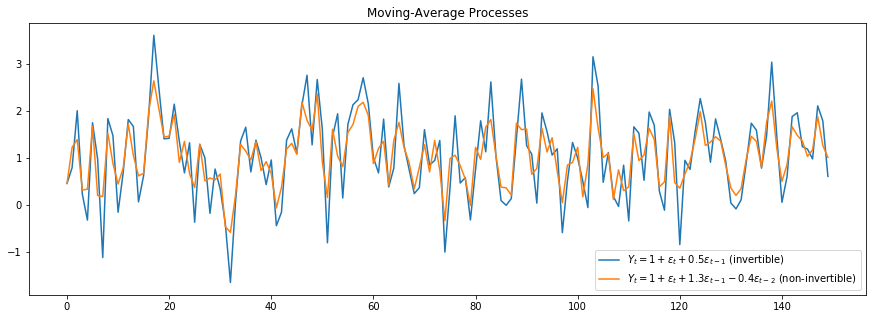

In [9]:
plt.figure(figsize = (15, 5))
plt.plot(B_data, label = "$Y_t = 1 + \\epsilon_t + 0.5 \\epsilon_{t-1}$ (invertible)")
plt.plot(A_data, label = "$Y_t = 1 + \\epsilon_t + 1.3 \\epsilon_{t-1} - 0.4 \\epsilon_{t-2}$ (non-invertible)")
plt.title("Moving-Average Processes")
plt.legend()
plt.show()

Notice that the plots do not exhibit large differences - you may not be able to tell whether a process is invertrible or not from the time series plots alone.

## (C) $Y_t = 1 + 1.1 Y_{t-1} + \epsilon_t$

The logic behind generating this process is as follows:
    
- when $t = 0$, we have $\epsilon_0 = 0$, $Y_0 = 0$
- when $t = 1$, we have $Y_1 = 1 + 1.1 \cdot Y_{0} + \epsilon_1 = 1 + \epsilon_1$
- when $t = 2$, we have $Y_2 = 1 + 1.1 \cdot Y_{1} + \epsilon_2 = 1 + 1.1 \cdot (1 + \epsilon_1) + \epsilon_2$
- when $t = 3$, we have $Y_3 = 1+ 1.1 Y_{2} + \epsilon_3 = 1 + 1.1 \cdot (1 + 1.1 \cdot (1 + \epsilon_1) + \epsilon_2) + \epsilon_3$
- etc.

we can carry out these calculations in `Python` as follows:

In [10]:
np.random.seed(123)
#
N = 150
epsilon = np.random.normal(loc = 0, scale = 0.5, size = N)
#
C_data = np.array(1 + epsilon[0], ndmin = 1)
for j in range(1, N):
    Y_temp = 1 + 1.1 * C_data[j - 1] + epsilon[j]
    C_data = np.append(C_data, Y_temp)

## (D) $Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t$

The logic behind generating this process is as follows:
    
- when $t = 0$, we have $\epsilon_0 = 0$, $Y_0 = 0$
- when $t = 1$, we have $Y_1 = 1 + 1.1 \cdot Y_{0} - 0.2 \cdot Y_{-1} + \epsilon_1 = 1 + \epsilon_1$
- when $t = 2$, we have $Y_2 = 1 + 1.1 \cdot Y_{1} - 0.2 \cdot Y_0 + \epsilon_2 = 1 + 1.1 \cdot (1 + \epsilon_1) + \epsilon_2$
- when $t = 3$, we have $Y_3 = 1+ 1.1 Y_{2} - 0.2 Y_{1} + \epsilon_3 = 1 + 1.1 \cdot (1 + 1.1 \cdot (1 + \epsilon_1) + \epsilon_2) - 0.2 \cdot (1 + \epsilon_1)+ \epsilon_3$
- etc.

we can carry out these calculations in `Python` as follows:

In [11]:
np.random.seed(123)
#
N = 150
epsilon = np.random.normal(loc = 0, scale = 0.5, size = N)
#
D_data = np.array(1 + epsilon[0], ndmin = 1)
D_data = np.append(D_data, 1 + 1.1 * D_data[0] + epsilon[1])
for j in range(2, N):
    Y_temp = 1 + 1.1 * D_data[j - 1] - 0.2 * D_data[j - 2] + epsilon[j]
    D_data = np.append(D_data, Y_temp)

We start the loop from `2` instead of `1`, since the first two elements include pas values of $Y$ at values $t \leq 0$, so they have a different formula.

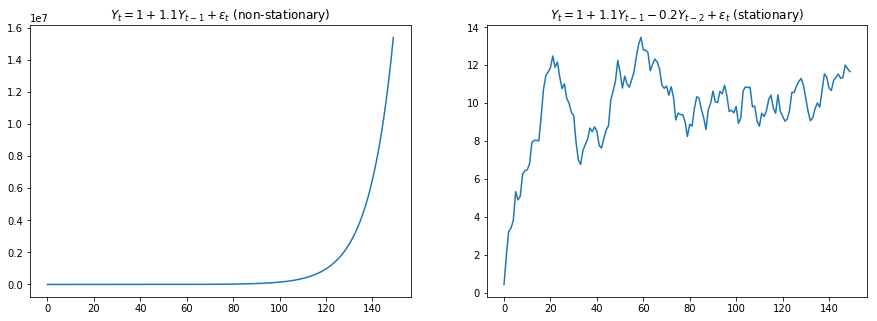

In [12]:
fig = plt.figure(figsize = (15, 5))
fig.add_subplot(1, 2, 1).plot(C_data)
plt.title("$Y_t = 1 + 1.1 Y_{t-1} + \\epsilon_t$ (non-stationary)")
fig.add_subplot(1, 2, 2).plot(D_data)
plt.title("$Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \\epsilon_t$ (stationary)")
plt.show()

## (E) $Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}$

The logic behind generating this process is as follows:
    
- when $t = 0$, we have $\epsilon_0 = 0$, $Y_0 = 0$
- when $t = 1$, we have $Y_1 = 1.1 \cdot Y_{0} - 0.2 \cdot Y_{-1} + \epsilon_1 + 1.3 \cdot \epsilon_0 = \epsilon_1$
- when $t = 2$, we have $Y_2 = 1.1 \cdot Y_{1} - 0.2 \cdot Y_0 + \epsilon_2 + 1.3 \cdot \epsilon_1 = 1.1 \cdot (1 + \epsilon_1) + \epsilon_2 + 1.3 \cdot \epsilon_1$
- when $t = 3$, we have $Y_3 = 1.1 Y_{2} - 0.2 Y_{1} + \epsilon_3 + 1.3 \cdot \epsilon_2 = 1.1 \cdot (1 + 1.1 \cdot (1 + \epsilon_1) + \epsilon_2 + 1.3 \cdot \epsilon_1) - 0.2 \cdot (1 + \epsilon_1)+ \epsilon_3 + 1.3 \cdot \epsilon_2$
- etc.

we can carry out these calculations in `Python` as follows:

In [13]:
np.random.seed(123)
#
N = 150
epsilon = np.random.normal(loc = 0, scale = 0.5, size = N)
#
E_data = np.array(epsilon[0], ndmin = 1)
E_data = np.append(E_data, 1.1 * E_data[0] + epsilon[1] + 1.3 * epsilon[0])
for j in range(2, N):
    Y_temp = 1.1 * E_data[j - 1] - 0.2 * E_data[j - 2] + epsilon[j] + 1.3 * epsilon[j - 1]
    E_data = np.append(E_data, Y_temp)

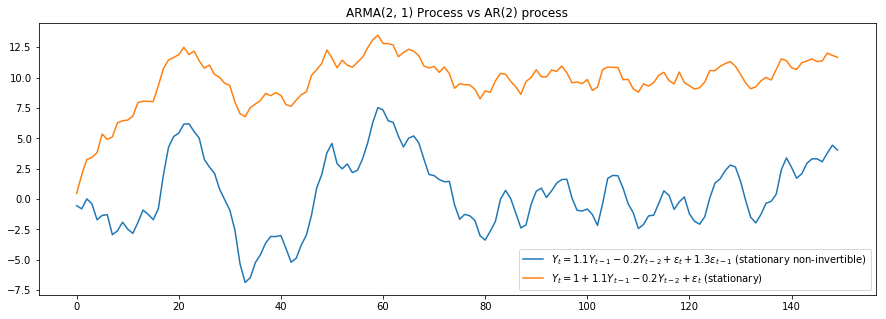

In [14]:
plt.figure(figsize = (15, 5))
plt.plot(E_data, label = "$Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \\epsilon_t + 1.3 \\epsilon_{t-1}$ (stationary non-invertible)")
plt.plot(D_data, label = "$Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \\epsilon_t$ (stationary)")
plt.title("ARMA(2, 1) Process vs AR(2) process")
plt.legend()
plt.show()

Note the difference in the mean - our $ARMA$ process does not have an intercept term.

---

Alternatively, we can use the built-in functions to simulate the models. We need to specify the $\Phi(z)$ and $\Theta(x)$ functions.

In [15]:
np.random.seed(123)
E_auto_spec = smt.arima_process.ArmaProcess(ar = np.array([1, -1.1, 0.2]), ma = [1, 1.3])
E_autogenr =  E_auto_spec.generate_sample(N, scale = 0.5)

Note that for puse $\rm AR$ models $\Theta(x) = 1$ and for pure $\rm MA$ models $\Phi(z) = 1$.

The nice thing about this function is that we can examine these lag functions

In [16]:
E_auto_spec.arpoly

Polynomial([ 1. , -1.1,  0.2], domain=[-1,  1], window=[-1,  1])

In [17]:
E_auto_spec.mapoly

Polynomial([1. , 1.3], domain=[-1,  1], window=[-1,  1])

as well as get their calculated roots 

In [18]:
E_auto_spec.arroots

array([1.14921894, 4.35078106])

In [19]:
E_auto_spec.maroots

array([-0.76923077])

and check the stationarity/invertibility automatically:

In [20]:
print("Stationarity: " + str(E_auto_spec.isstationary))
print("Invertibility: " + str(E_auto_spec.isinvertible))

Stationarity: True
Invertibility: False


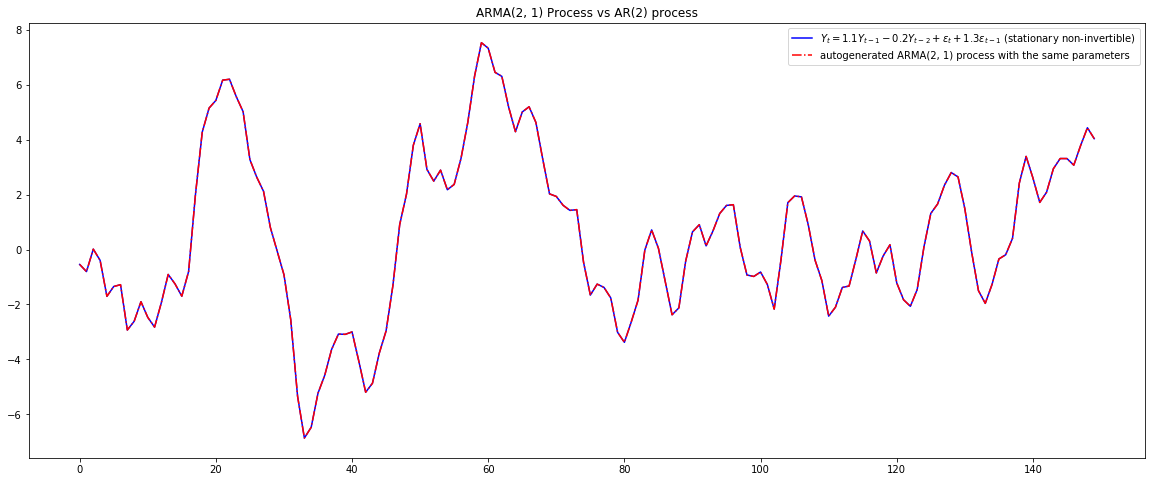

In [21]:
plt.figure(figsize = (20, 8))
plt.plot(E_data, label = "$Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \\epsilon_t + 1.3 \\epsilon_{t-1}$ (stationary non-invertible)", color = "blue")
plt.plot(E_autogenr, label = "autogenerated ARMA(2, 1) process with the same parameters", linestyle = "-.", color = "red")
plt.title("ARMA(2, 1) Process vs AR(2) process")
plt.legend()
plt.show()

Note - we used the same innovations to generate (A) - (E) processes, and the autogenerated used different innovations simulated via the same specified seed.

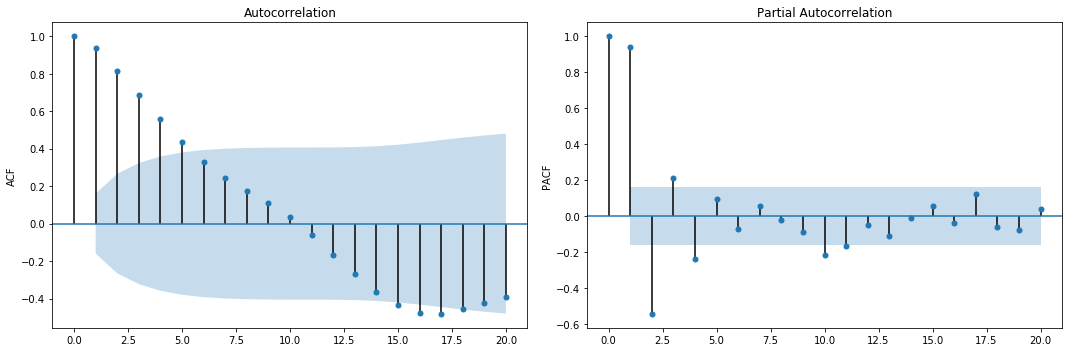

In [22]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(E_autogenr, lags = 20, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(E_autogenr, lags = 20, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

[NOTE on possible PACF error](https://github.com/statsmodels/statsmodels/issues/4663), need to specify either `method = "ywm"`, or `method = "ols"`

---

## 1.3 The Mean of the processes

We remember that $\epsilon_t \sim \mathcal{N}(0, 0.5^2)$.

- (A) $\mathbb{E} (Y_t) = \mathbb{E} (1 + \epsilon_t + 0.5 \epsilon_{t-1}) = 1$

In [23]:
print(A_data.mean())

1.043106649424549


- (B) $\mathbb{E} (Y_t) = \mathbb{E} (1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}) = 1$

In [24]:
print(B_data.mean())

1.05415481291134


- (C) $\mathbb{E} (Y_t) = \mathbb{E} (1 + 1.1 Y_{t-1} + \epsilon_t) = 1 + 1.1 \mathbb{E} (Y_{t-1}) = 1 + 1.1 + (1.1)^2 \mathbb{E} (Y_{t-2}) = 1 + 1.1 + (1.1)^2 + (1.1)^3 \mathbb{E} (Y_{t-2}) = ... = \sum_{j = 0}^\infty (1.1)^j = \infty$. 

Assuming that $Y_t = 0$ for $t \leq 0$, this can be expressed as $\mathbb{E} (Y_t) =\sum_{j = 0}^{t-1} (1.1)^j$ for an $AR(1)$ process. So, for $t = 150$ this is roughly

In [25]:
tmp_sum = 0
for i in range(0, N):
    tmp_sum = tmp_sum + (1.1)**i
print(tmp_sum)

16177168.357762082


In [26]:
print(C_data.mean())

1129986.8195605408


An example of a non-stationary process - a non-constant mean.

- (D) $\mathbb{E} (Y_t) = \mathbb{E} (1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t) = 1 + 1.1 \mathbb{E} (Y_{t-1}) - 0.2 \mathbb{E} (Y_{t-2})$. For a stationary process $\mathbb{E} (Y_t) = \mu$, which gives $\mu = 1 + 1.1 \mu - 0.2 \mu$, which gives $\mu = \dfrac{1}{1 - 1.1 + 0.2} = \dfrac{1}{0.1} = 10$.

In [27]:
print(D_data.mean())

9.7463508691281


- (E) $\mathbb{E} (Y_t) = \mathbb{E} (1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}) = 1.1 \mathbb{E} (Y_{t-1}) - 0.2 \mathbb{E} (Y_{t-2})$. Since $Y_t$ is stationary and invertible, we can write it as an infinite MA process. Furthermore, for a stationary process $\mathbb{E} (Y_t) = \mu$, which gives $\mu = 1.1 \mu - 0.2 \mu \Longrightarrow \mu = 0$.

In [28]:
print(E_data.mean())

0.4754671302890322


## 1.4 ACF and PACF plots 

- (A) $Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}$

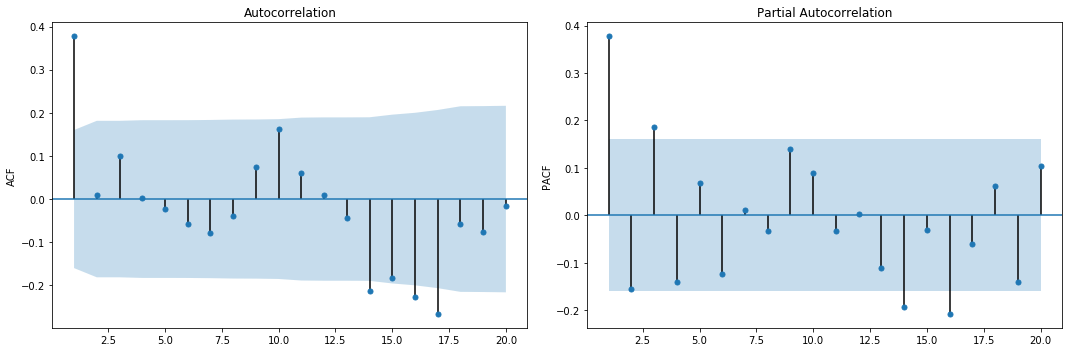

In [29]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(A_data, lags = 20, zero = False, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(A_data, lags = 20, zero = False, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

We see that the ACF is abruptly cutoff after the first lag. Regarding PACF - it appears to be somewhat declining, though it is difficult to say. We expect it to be an MA(1) process.

- (B) $Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}$

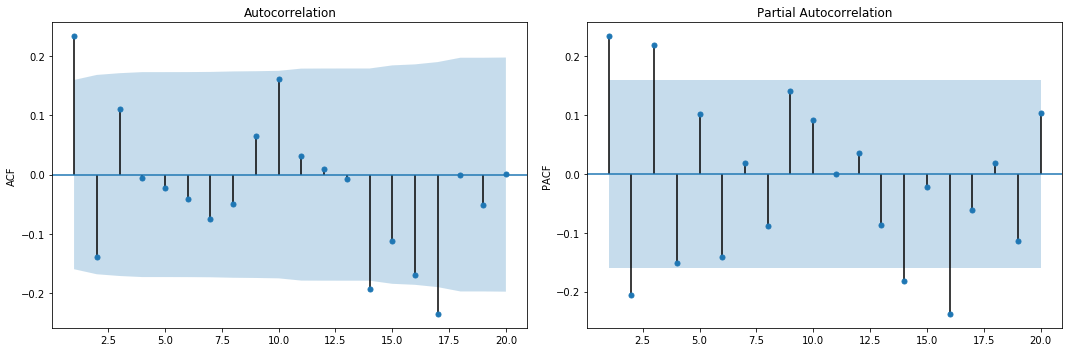

In [30]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(B_data, lags = 20, zero = False, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(B_data, lags = 20, zero = False, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

We see that the ACF is abruptly cutoff after the first lag. Regarding PACF - it appears to be somewhat declining, though it is difficult to say. We would expect an MA(1) process (though in reality we know that it is an MA(2) process).

- (C) $Y_t = 1 + 1.1 Y_{t-1} + \epsilon_t$

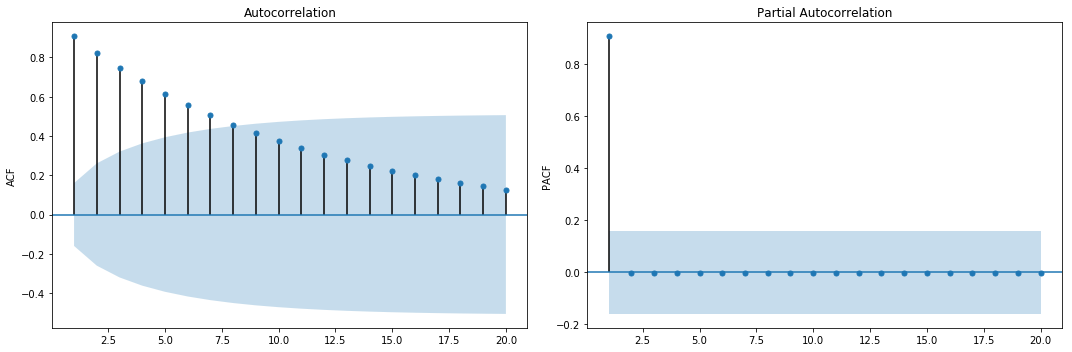

In [31]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(C_data, lags = 20, zero = False, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(C_data, lags = 20, zero = False, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

The ACF appears to decline, while the PACF is abruptly cutoff after the first lag. We would expect an AR(1) process.

- (D) $Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t$

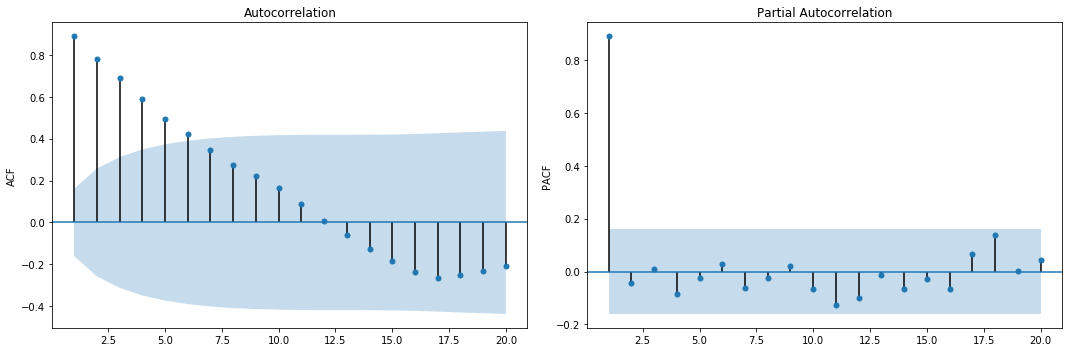

In [32]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(D_data, lags = 20, zero = False, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(D_data, lags = 20, zero = False, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

The ACF appears to decline, while the PACF is abruptly cutoff after the first lag. We would expect an AR(1) process (though in reality it is an AR(2) process).

**(Try to increase the sample size and re-examine the ACf/PACF plots - are they closer to the true theoretical cases?)**

- (E) $Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}$

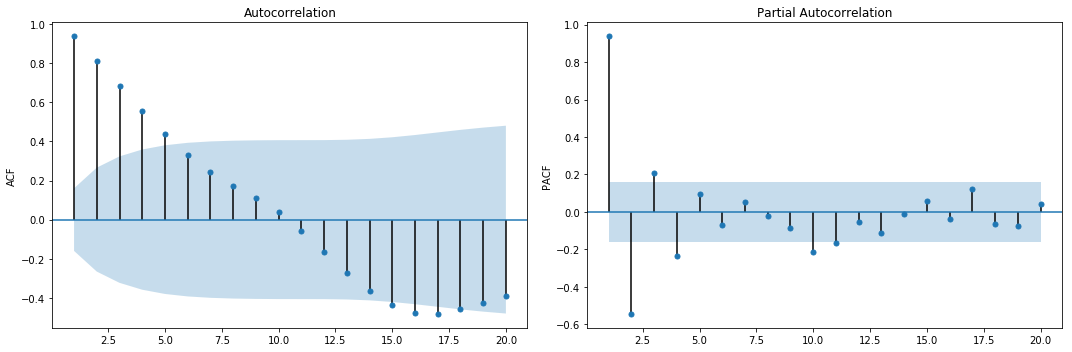

In [33]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(E_data, lags = 20, zero = False, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(E_data, lags = 20, zero = False, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

We see both the ACF and PACF to be declining - it is an ARMA process. We cannot identify its order from these plots alone.

----

Note that if we have automatically generated the data using `smt.arima_process.ArmaProcess`, we can examine the theoretical acf/pacf plots

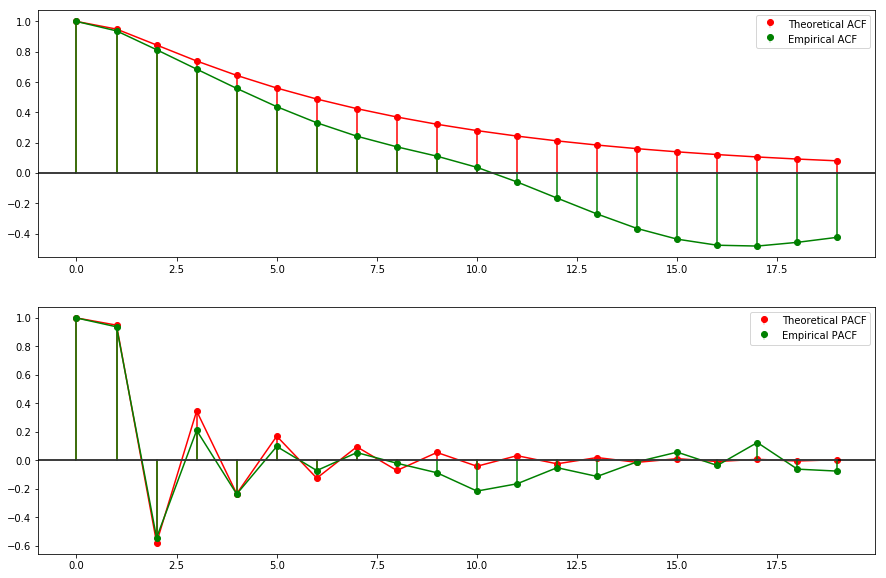

In [34]:
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(211)
ax1.stem(E_auto_spec.acf(lags = 20), label = "Theoretical ACF", basefmt = "white", linefmt = "r-", markerfmt = "ro-")
ax1.stem(smt.stattools.acf(E_autogenr, nlags = 19), label = "Empirical ACF", basefmt = "white", linefmt = "g-", markerfmt = "go-")
ax1.axhline(y = 0, color = "black")
plt.legend()
ax2 = fig.add_subplot(212)
ax2.stem(E_auto_spec.pacf(lags = 20), label = "Theoretical PACF", basefmt = "white", linefmt = "r-", markerfmt = "ro-")
ax2.stem(smt.stattools.pacf(E_autogenr, nlags = 19, method = "ywm"), label = "Empirical PACF", basefmt = "white", linefmt = "g-", markerfmt = "go-")
ax2.axhline(y = 0, color = "black")
plt.legend()
plt.show()

---

As an example, we will re-generate the process but with a larger sample size of $N = 1500$

In [35]:
np.random.seed(123)
E_autogenr_large =  E_auto_spec.generate_sample(1500, scale = 0.5)

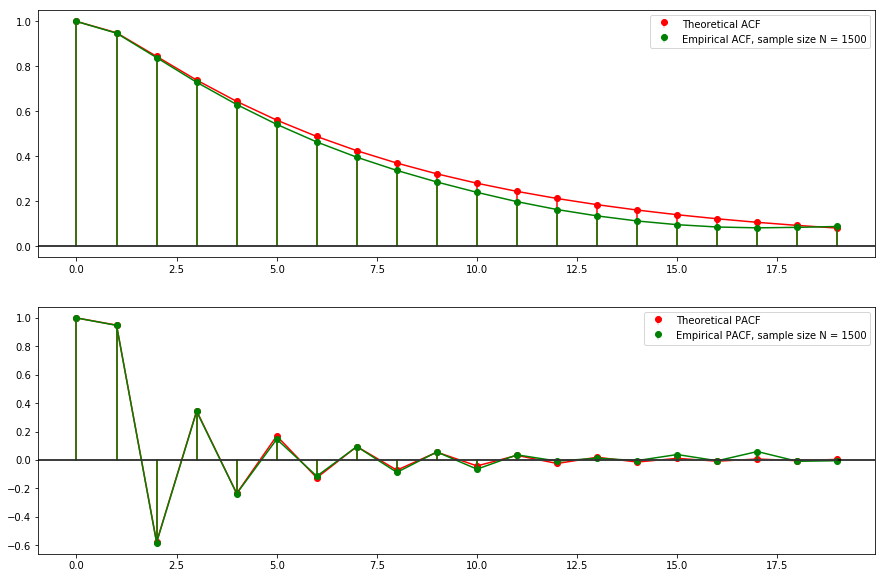

In [36]:
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(211)
ax1.stem(E_auto_spec.acf(lags = 20), label = "Theoretical ACF", basefmt = "white", linefmt = "r-", markerfmt = "ro-")
ax1.stem(smt.stattools.acf(E_autogenr_large, nlags = 19), label = "Empirical ACF, sample size N = 1500", basefmt = "white", linefmt = "g-", markerfmt = "go-")
ax1.axhline(y = 0, color = "black")
plt.legend()
ax2 = fig.add_subplot(212)
ax2.stem(E_auto_spec.pacf(lags = 20), label = "Theoretical PACF", basefmt = "white", linefmt = "r-", markerfmt = "ro-")
ax2.stem(smt.stattools.pacf(E_autogenr_large, nlags = 19, method = "ywm"), label = "Empirical PACF, sample size N = 1500", basefmt = "white", linefmt = "g-", markerfmt = "go-")
ax2.axhline(y = 0, color = "black")
plt.legend()
plt.show()

The following result is important to note: **the larger the sample size, the closer the estimates to the true values**.

---

## 2.1 Model Estimation

We will estimate the models with the exact order that we used to generate the data:

- (A) $Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}$

In [37]:
A_spec_1 = smt.arima_model.ARMA(A_data, order = (0, 1))
A_mdl_1 = A_spec_1.fit(trend = 'c')

In [38]:
print(A_mdl_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  150
Model:                     ARMA(0, 1)   Log Likelihood                -121.404
Method:                       css-mle   S.D. of innovations              0.543
Date:                Thu, 28 Feb 2019   AIC                            248.808
Time:                        23:16:42   BIC                            257.840
Sample:                             0   HQIC                           252.477
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0412      0.070     14.877      0.000       0.904       1.178
ma.L1.y        0.5830      0.084      6.934      0.000       0.418       0.748
                                    Roots           

- (B) $Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}$

In [39]:
B_spec_1 = smt.arima_model.ARMA(B_data, order = (0, 2))
B_mdl_1 = B_spec_1.fit(trend = 'c')

In [40]:
print(B_mdl_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  150
Model:                     ARMA(0, 2)   Log Likelihood                -187.015
Method:                       css-mle   S.D. of innovations              0.840
Date:                Thu, 28 Feb 2019   AIC                            382.030
Time:                        23:16:42   BIC                            394.073
Sample:                             0   HQIC                           386.923
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0547      0.080     13.113      0.000       0.897       1.212
ma.L1.y        0.4276      0.075      5.718      0.000       0.281       0.574
ma.L2.y       -0.2559      0.071     -3.588      0.0

Note that the coefficients are not close to the true values (except for the constant and the overall coefficient signs). This is because our true process is not invertible. Hence, the software attepts to fit an invertible model, which results in different coefficients.

- (C) $Y_t = 1 + 1.1 Y_{t-1} + \epsilon_t$

In [41]:
C_spec_1 = smt.arima_model.ARMA(C_data, order = (1, 0))
C_mdl_1 = C_spec_1.fit(trend = 'c')

In [42]:
print(C_mdl_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  150
Model:                     ARMA(1, 0)   Log Likelihood               -2095.353
Method:                       css-mle   S.D. of innovations         275467.476
Date:                Thu, 28 Feb 2019   AIC                           4196.706
Time:                        23:16:42   BIC                           4205.738
Sample:                             0   HQIC                          4200.375
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.13e+06   2.59e+07      0.044      0.965   -4.96e+07    5.18e+07
ar.L1.y        0.9996      0.001    682.766      0.000       0.997       1.002
                                    Roots           

Note the coefficient values for the non-stationary process.

- (D) $Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t$

In [43]:
D_spec_1 = smt.arima_model.ARMA(D_data, order = (2, 0))
D_mdl_1 = D_spec_1.fit(trend = 'c')

In [44]:
print(D_mdl_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  150
Model:                     ARMA(2, 0)   Log Likelihood                -134.551
Method:                       css-mle   S.D. of innovations              0.586
Date:                Thu, 28 Feb 2019   AIC                            277.103
Time:                        23:16:42   BIC                            289.145
Sample:                             0   HQIC                           281.995
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2087      2.598      3.160      0.002       3.117      13.300
ar.L1.y        1.2268      0.081     15.165      0.000       1.068       1.385
ar.L2.y       -0.2424      0.083     -2.937      0.0

Note the `const` coefficient of the model is close to the process mean. This is **not the intercept!**

- (E) $Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}$

In [45]:
E_spec_1 = smt.arima_model.ARMA(E_data, order = (2, 1))
E_mdl_1 = E_spec_1.fit(trend = 'nc')

In [46]:
print(E_mdl_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  150
Model:                     ARMA(2, 1)   Log Likelihood                -162.225
Method:                       css-mle   S.D. of innovations              0.703
Date:                Thu, 28 Feb 2019   AIC                            332.449
Time:                        23:16:42   BIC                            344.492
Sample:                             0   HQIC                           337.342
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.0358      0.088     11.829      0.000       0.864       1.207
ar.L2.y       -0.1487      0.088     -1.691      0.093      -0.321       0.024
ma.L1.y        0.8466      0.041     20.776      0.0

Note that we use `trend` to decide whether to include a constant or not. `c` includes constant, `nc` -  no constant.

We can also see the roots for stationarity and invertibility. Again, the fitted model attempts to fit a stationary and invertible process, hence the MA coefficient is different for this process (which is generated from a non-invertible data generating process).

We can also extract specific information about the model:

In [47]:
print("Included trend (this is actually the constant): ", E_mdl_1.k_trend)
print("Included constat: ", E_mdl_1.k_constant)
print("Number of AR parameters: ", E_mdl_1.k_ar)
print("Number of MA parameters" , E_mdl_1.k_ma)
print("Included exogenous variables: ", E_mdl_1.k_exog)

Included trend (this is actually the constant):  0
Included constat:  0
Number of AR parameters:  2
Number of MA parameters 1
Included exogenous variables:  0


as well as specific parameters

In [48]:
print("All of the parameters: ", E_mdl_1.params)
print("All of the p-values: ", E_mdl_1.pvalues)
print("Only AR parameters: ", E_mdl_1.arparams)
print("Only MA parameters: ", E_mdl_1.maparams)

All of the parameters:  [ 1.03584648 -0.14873211  0.84664303]
All of the p-values:  [4.20333223e-23 9.29576875e-02 1.38602032e-45]
Only AR parameters:  [ 1.03584648 -0.14873211]
Only MA parameters:  [0.84664303]


---

Interestingly, on the larger sample size the autoregressive parameters are indeed close to the true values

In [49]:
print(smt.arima_model.ARMA(E_autogenr_large, order = (2, 1)).fit(trend = 'nc').summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1500
Model:                     ARMA(2, 1)   Log Likelihood               -1443.342
Method:                       css-mle   S.D. of innovations              0.632
Date:                Thu, 28 Feb 2019   AIC                           2894.684
Time:                        23:16:43   BIC                           2915.937
Sample:                             0   HQIC                          2902.601
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.1010      0.030     36.920      0.000       1.043       1.159
ar.L2.y       -0.2045      0.030     -6.881      0.000      -0.263      -0.146
ma.L1.y        0.7826      0.019     40.846      0.0

However, the moving-average parameters are not, since the process is non-invertible.

The estimated model is:
    
$
\widehat{Y}_t = 1.1010 \cdot \widehat{Y}_{t-1} - 0.2045 \cdot \widehat{Y}_{t-2} + e_t + 0.7826 \cdot e_{t-1}
$

where $e_t = Y_t - 1.1010 \cdot \widehat{Y}_{t-1} + 0.2045 \cdot \widehat{Y}_{t-2} - 0.7826 \cdot e_{t-1}$ and $e_0 = 0$.

We will see more on model fitting in the last task.

---

## 2.2 Automatic order selection

We will automatically etimate the unknown parameters as well as the lag order. Note the documentation:
``
This method can be used to tentatively identify the order of an ARMA process, provided that the time series is stationary and invertible.
``

- (A) $Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}$

In [50]:
A_est_auto = sm.tsa.stattools.arma_order_select_ic(A_data, ic='aic', trend='c')

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
c:\users\andrius\ap

In [51]:
print("(A) process order: ", A_est_auto.aic_min_order)

(A) process order:  (1, 1)


The automatically selected model is:

In [52]:
A_mdl_auto = smt.arima_model.ARMA(A_data, order = A_est_auto.aic_min_order).fit(trend = 'c')
print(A_mdl_auto.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0419      0.062     16.741      0.000       0.920       1.164
ar.L1.y       -0.2248      0.123     -1.833      0.069      -0.465       0.016
ma.L1.y        0.7393      0.083      8.959      0.000       0.578       0.901


c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


If we wanted, we could restrict the models by specifying the maximum order of the $MA$ or the $AR$ (or both) parts:

In [53]:
A_est_auto = sm.tsa.stattools.arma_order_select_ic(A_data, ic='aic', trend='c', max_ar = 0)
print("(A) process order: ", A_est_auto.aic_min_order)

(A) process order:  (0, 2)


- (B) $Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}$

In [54]:
B_est_auto = sm.tsa.stattools.arma_order_select_ic(B_data, ic='aic', trend='c')

In [55]:
print("(B) process order: ", B_est_auto.aic_min_order)

(B) process order:  (1, 1)


The automatically selected model is:

In [56]:
B_mdl_auto = smt.arima_model.ARMA(B_data, order = B_est_auto.aic_min_order).fit(trend = 'c')
print(B_mdl_auto.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0542      0.089     11.817      0.000       0.879       1.229
ar.L1.y       -0.3954      0.101     -3.904      0.000      -0.594      -0.197
ma.L1.y        0.8184      0.055     14.846      0.000       0.710       0.926


- (C) $Y_t = 1 + 1.1 Y_{t-1} + \epsilon_t$

In [57]:
C_est_auto = sm.tsa.stattools.arma_order_select_ic(C_data, ic='aic', trend='c')

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.ex

In [58]:
print("(C) process order: ", C_est_auto.aic_min_order)

(C) process order:  (1, 2)


Since our process is non-stationary, we will get an error when estimating. To make the error more compact, we will wrapt the function in a try-catch block:

In [59]:
try:
    C_mdl_auto = smt.arima_model.ARMA(C_data, order = C_est_auto.aic_min_order).fit(trend = 'c')
    print(C_mdl_auto.summary().tables[1])
except ValueError as err:
        print('Handling run-time error:', err)

Handling run-time error: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


So our suggestions are to either (a) induce stationarity; or (b) choose a different model order. Since we know that it is non-stationary, we may try to specify an $\rm ARMA(2, 2)$ model and hope that the $\rm AR$ coefficients approximately stationary, or a pure $\rm MA$ model. We will go with a pure $MA$ process, since they are always stationary (though they may not be the best fit on the data). We opt to choose an order automatically.

Note that for larger orders the calculations take a while, so we restrict to $q_\max = 6$ (default max is 2 for $\rm MA$ and $p_\max = 4$ for $\rm AR$).

In [60]:
C_mdl_auto = sm.tsa.stattools.arma_order_select_ic(C_data, ic='aic', trend='c', max_ar = 0, max_ma = 6)

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packa

In [61]:
print("(C) process order: ", C_mdl_auto.aic_min_order)

(C) process order:  (0, 5)


In [62]:
C_mdl_auto = smt.arima_model.ARMA(C_data, order = C_mdl_auto.aic_min_order).fit(trend = 'c')
print(C_mdl_auto.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.13e+06   2.86e+05      3.946      0.000    5.69e+05    1.69e+06
ma.L1.y        4.7261        nan        nan        nan         nan         nan
ma.L2.y        9.1501        nan        nan        nan         nan         nan
ma.L3.y        9.0670      0.003   3145.519      0.000       9.061       9.073
ma.L4.y        4.5973      0.002   1994.273      0.000       4.593       4.602
ma.L5.y        0.9542      0.001    665.206      0.000       0.951       0.957


c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encount

Note again that the non-stationarity of the process is quite a problem even looking at the results - some standard errors are `nan`.

- (D) $Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t$

In [63]:
D_est_auto = sm.tsa.stattools.arma_order_select_ic(D_data, ic='aic', trend='c')

In [64]:
print("(D) process order: ", D_est_auto.aic_min_order)

(D) process order:  (1, 1)


The automatically selected model is:

In [65]:
D_mdl_auto = smt.arima_model.ARMA(D_data, order = D_est_auto.aic_min_order).fit(trend = 'c')
print(D_mdl_auto.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1185      2.745      2.958      0.004       2.739      13.498
ar.L1.y        0.9820      0.019     51.786      0.000       0.945       1.019
ma.L1.y        0.2638      0.089      2.975      0.003       0.090       0.438


- (E) $Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}$

In [66]:
E_est_auto = sm.tsa.stattools.arma_order_select_ic(E_data, ic='aic', trend='nc')

In [67]:
print("(E) process order: ", E_est_auto.aic_min_order)

(E) process order:  (2, 2)


Note that we would expect to have problems with (B) and (C), since the function requires stationarity and invertibility. 

Note that in the case of (A), specifying `max_ar = 0` returns a result without any warnings. This is a current drawback of this method as it does not automatically distringuish when an order of `0` is appropriate for either MA, or AR components. **Update: after a package update some warnings may have disappeared.** 

Either way, in all cases the final suggested models are ARMA models, instead of pure AR or pure MA models.

The automatically selected model is:

In [68]:
E_mdl_auto = smt.arima_model.ARMA(E_data, order = E_est_auto.aic_min_order).fit(trend = 'nc')
print(E_mdl_auto.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.8674      0.045     41.834      0.000       1.780       1.955
ar.L2.y       -0.8886      0.041    -21.683      0.000      -0.969      -0.808
ma.L1.y       -0.0674      0.060     -1.130      0.260      -0.184       0.050
ma.L2.y       -0.8044      0.056    -14.356      0.000      -0.914      -0.695


---

For the larger sample size

In [69]:
print("(E) process with larger sample order: ", sm.tsa.stattools.arma_order_select_ic(E_autogenr_large, ic='aic', trend='nc').aic_min_order)

(E) process with larger sample order:  (2, 1)


The suggested process is actually the same order as the true underlying process. Note that because of the non-invertibility of the process this may not always be the case. 

If the process was both stationary and ivnertible, then it is very likely that for a larger sample, the automated order selection would suggest a model order, which is close to the true process, as long as the true underlying process is an $\rm ARMA(p, q)$ process.

---

## 2.3 Stationarity/Invertibility

We will show with (A) since it is both stationary and invertible.

- (A) $Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}$

rewriting as an $AR(\infty)$ process yields $Y_t = \alpha + \sum_{j = 1}^\infty (-1)^{j+1} \theta^j Y_{t-j} + \epsilon_t$ with coefficients:

In [70]:
theta_coef = 0.5
for j in range(2, 10):
    theta_coef = np.append(theta_coef, (-1)**(j+1)*0.5**j)
print(theta_coef)    

[ 0.5        -0.25        0.125      -0.0625      0.03125    -0.015625
  0.0078125  -0.00390625  0.00195312]


A manually specified arbitrary approximation could be, for example, an $\rm AR(10)$ process:

In [71]:
A_spec_2 = smt.arima_model.ARMA(A_data, order = (10, 0))
A_mdl_2 = A_spec_2.fit(trend = 'c')

In [72]:
print(A_mdl_2.summary().tables[0])

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  150
Model:                    ARMA(10, 0)   Log Likelihood                -116.997
Method:                       css-mle   S.D. of innovations              0.526
Date:                Thu, 28 Feb 2019   AIC                            257.994
Time:                        23:17:05   BIC                            294.122
Sample:                             0   HQIC                           272.671
                                                                              


In [73]:
print(A_mdl_2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0411      0.077     13.584      0.000       0.891       1.191
ar.L1.y        0.5070      0.082      6.216      0.000       0.347       0.667
ar.L2.y       -0.3166      0.091     -3.468      0.001      -0.496      -0.138
ar.L3.y        0.3289      0.095      3.466      0.001       0.143       0.515
ar.L4.y       -0.2270      0.098     -2.308      0.022      -0.420      -0.034
ar.L5.y        0.1655      0.099      1.672      0.097      -0.029       0.360
ar.L6.y       -0.1706      0.100     -1.710      0.089      -0.366       0.025
ar.L7.y        0.0634      0.099      0.637      0.525      -0.132       0.258
ar.L8.y       -0.0907      0.097     -0.936      0.351      -0.281       0.099
ar.L9.y        0.0983      0.094      1.046      0.297      -0.086       0.283
ar.L10.y       0.0891      0.083      1.072      0.2

In [74]:
print(A_mdl_2.summary().tables[2])

                                    Roots                                     
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1914           -0.0000j            1.1914           -0.0000
AR.2             0.9694           -0.6337j            1.1581           -0.0921
AR.3             0.9694           +0.6337j            1.1581            0.0921
AR.4             0.3457           -1.1340j            1.1855           -0.2029
AR.5             0.3457           +1.1340j            1.1855            0.2029
AR.6            -0.3935           -1.1564j            1.2215           -0.3022
AR.7            -0.3935           +1.1564j            1.2215            0.3022
AR.8            -0.9955           -0.7541j            1.2489           -0.3968
AR.9            -0.9955           +0.7541j            1.2489            0.3968
AR.10           -2.1472           -0.0000j          

We can also try to automatically fit the best AR model:

In [75]:
A_est_auto = sm.tsa.stattools.arma_order_select_ic(A_data, ic='aic', trend='c', max_ma = 0)
print("(A) process order: ", A_est_auto.aic_min_order)

(A) process order:  (4, 0)


In [76]:
A_spec_2 = smt.arima_model.ARMA(A_data, order = A_est_auto.aic_min_order)
A_mdl_2 = A_spec_2.fit(trend = 'c')

In [77]:
print(A_mdl_2.summary2())

                          Results: ARMA
Model:              ARMA             BIC:                 271.6677
Dependent Variable: y                Log-Likelihood:      -120.80 
Date:               2019-02-28 23:17 Scale:               1.0000  
No. Observations:   150              Method:              css-mle 
Df Model:           5                Sample:              0       
Df Residuals:       145                                   0       
Converged:          1.0000           S.D. of innovations: 0.541   
No. Iterations:     10.0000          HQIC:                260.943 
AIC:                253.6039                                      
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       1.0426     0.0662   15.7606   0.0000    0.9129    1.1722
ar.L1.y     0.4917     0.0808    6.0831   0.0000    0.3333    0.6502
ar.L2.y    -

Note the different coefficients. This is because the lower level model is a sort of approximation of the higher order model.

We leave the remaining cases as excercises.

----

From our automatically simulated data, we can transform it into a pure AR, or pure MA process of different orders:

In [78]:
E_auto_spec.arma2ma(lags = 5)

array([1.    , 2.4   , 2.44  , 2.204 , 1.9364])

In [79]:
E_auto_spec.arma2ar(lags = 5)

array([ 1.    , -2.4   ,  3.32  , -4.316 ,  5.6108])

Though looking at the documentation ([here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.arma2ma.html) and [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.arma2ma.html) ), thie should be used with caution as it lacks documentation and examples.

---

## 3 Residual Diagnostics: (3.1), (3.2) and (3.3)

Remember that our underlying assumption is that $\epsilon_t \sim WN$. In other words the residuals:

- must be zero-mean;
- must have a constant variance;
- must not be autocorrelated;

The zero-mean property is guaranteed by the estimation method (the proof is similar to the OLS estimation method, which minimizes the sum of squared residuals in the univariate cros-sectional regression case). We can examine the variance by checkign for ARCH effects. For the purpose of these exercises, we will examine the variance only visually.

We note that, unlike `forecast` in `R`, the `statsmodels` package in `Python` does not have the `tsdisplay` function. Fortunately, we can always create one ourselves for simplicity:

In [80]:
import pandas as pd

In [81]:
def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40, normed = 1)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()

Furthermore, the `tsdiag`, available in `R`, does not have an analog in `statsmodels`. Neverhteless, we can create our own:

In [82]:
def tsdiag(y, figsize = (14, 8), title = "", lags = 30):
    tmp_data = pd.Series(y)
    tmp_data.index += 1
    tmp_acor = list(sm_stat.diagnostic.acorr_ljungbox(tmp_data, lags = lags, boxpierce = True))
    # Plot Ljung-Box and Box-Pierce statistic p-values:
    plt.plot(range(1, len(tmp_acor[0]) + 1), tmp_acor[1], 'bo', label = "Ljung-Box values")
    plt.plot(range(1, len(tmp_acor[0]) + 1), tmp_acor[3], 'go', label = "Box-Pierce values")
    plt.xticks(np.arange(1,  len(tmp_acor[0]) + 1, 1.0))
    plt.axhline(y = 0.05, color = "red", label = "5% critical value")
    plt.title("$Time\ Series\ " + title + "$")
    plt.legend()
    plt.show()
    # Return the statistics:
    col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
    return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))

We now examine the residuals of our models:

- (A) $Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}$

The residuals of the true model:

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


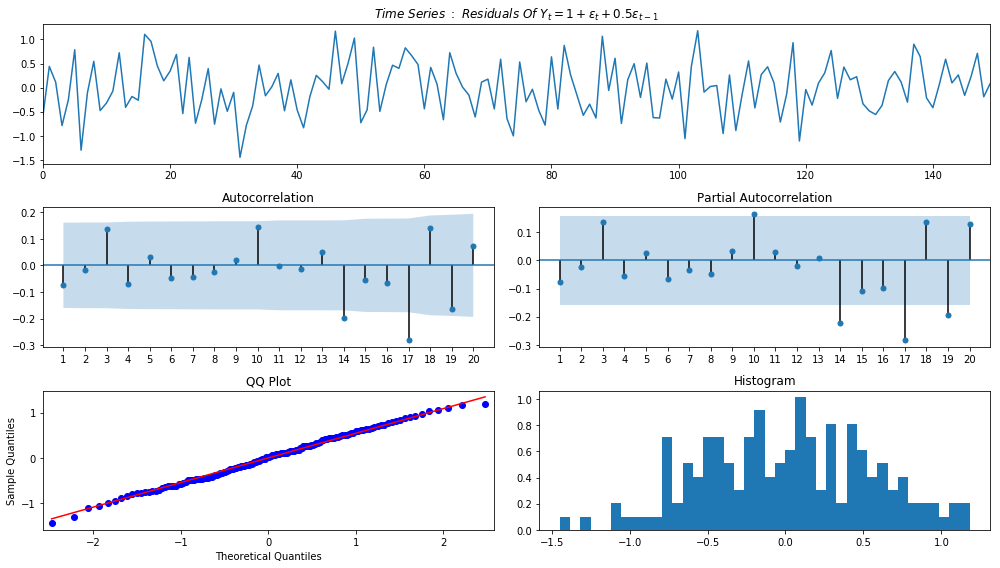

In [83]:
tsdisplay(A_mdl_1.resid, title = ":\ Residuals\ Of\ Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}")

We now want to test the null hypothesis of no autocorrelation:

$
\begin{aligned}
H_0 &: \rho(1) = ... = \rho(k) = 0\\
H_1 &: \exists j: \rho(j) \neq 0
\end{aligned}
$

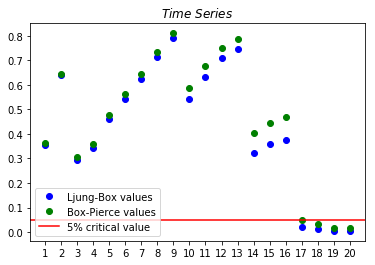

1         2         3         4         5   \
Ljung-Box: X-squared   0.851592  0.897112  3.717511  4.512690  4.655322   
Ljung-Box: p-value     0.356102  0.638549  0.293628  0.341045  0.459375   
Box-Pierce: X-squared  0.834784  0.879107  3.606729  4.370520  4.506583   
Box-Pierce: p-value    0.360893  0.644324  0.307181  0.358178  0.479003   

                             6         7         8         9         10  \
Ljung-Box: X-squared   5.013634  5.301643  5.406308  5.465344  8.879360   
Ljung-Box: p-value     0.542066  0.623204  0.713397  0.792005  0.543590   
Box-Pierce: X-squared  4.846036  5.116992  5.214771  5.269535  8.414024   
Box-Pierce: p-value    0.563707  0.645689  0.734394  0.810208  0.588464   

                             11        12        13         14         15  \
Ljung-Box: X-squared   8.880706  8.905556  9.339951  15.826280  16.368779   
Ljung-Box: p-value     0.632903  0.710975  0.746811   0.324098   0.357975   
Box-Pierce: X-squared  8.415254  8.437816  8.829342  14.632900  15.114725   
Box-Pierce: p-value    0.675694  0.750049  0.785707   0.403700   0.443185   

                              16         17         18         19         20  
Ljung-Box: X-squared   17.136399  30.750781  34.102257  38.842286  39.786784  
Ljung-Box: p-value      0.376824   0.021412   0.012234   0.004629   0.005315  
Box-Pierce: X-squared  15.791442  27.704027  30.614519  34.699676  35.507470  
Box-Pierce: p-value     0.467609   0.048518   0.031884   0.015176   0.017562

In [84]:
tsdiag(A_mdl_1.resid, lags = 20)

For the first `16` lags we have that $p-value > 0.05$, which means we have no groudns to reject the null hypothesis of no correlation. For larger lag values, there is significant autocorrelation with $p-value < 0.05$, though it occurs only at `lag > 16`.

Looking at the automatically-selected order model residuals we see similar results:

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


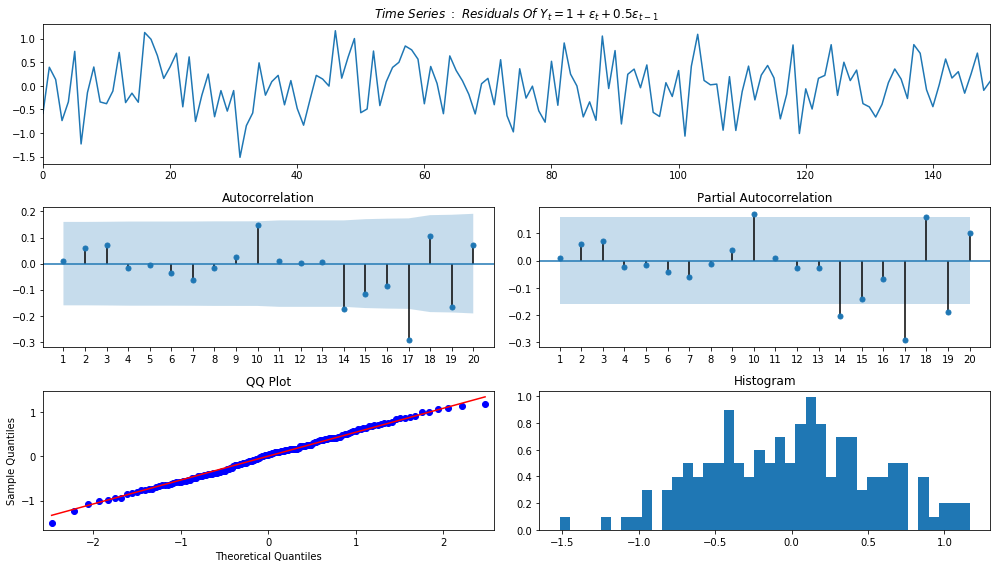

In [85]:
tsdisplay(A_mdl_auto.resid, title = ":\ Residuals\ Of\ Y_t = 1 + \epsilon_t + 0.5 \epsilon_{t-1}")

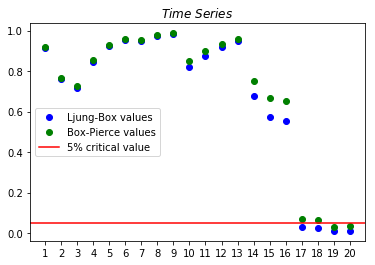

1         2         3         4         5   \
Ljung-Box: X-squared   0.011121  0.542495  1.344951  1.388037  1.393709   
Ljung-Box: p-value     0.916015  0.762428  0.718488  0.846272  0.925000   
Box-Pierce: X-squared  0.010901  0.528292  1.304351  1.345736  1.351147   
Box-Pierce: p-value    0.916844  0.767861  0.728100  0.853569  0.929582   

                             6         7         8         9         10  \
Ljung-Box: X-squared   1.593206  2.190526  2.236515  2.341315  5.944853   
Ljung-Box: p-value     0.953065  0.948547  0.972889  0.984851  0.819875   
Box-Pierce: X-squared  1.540144  2.102097  2.145060  2.242277  5.561324   
Box-Pierce: p-value    0.956783  0.953974  0.976239  0.987031  0.850675   

                             11        12        13         14         15  \
Ljung-Box: X-squared   5.963415  5.964616  5.972912  11.096040  13.351420   
Ljung-Box: p-value     0.875794  0.917855  0.947133   0.678475   0.575174   
Box-Pierce: X-squared  5.578299  5.579389  5.586866  10.170717  12.173852   
Box-Pierce: p-value    0.899969  0.935785  0.959906   0.749599   0.665825   

                              16         17         18         19         20  
Ljung-Box: X-squared   14.615806  29.499755  31.382707  36.131818  37.007011  
Ljung-Box: p-value      0.552937   0.030187   0.025986   0.010169   0.011679  
Box-Pierce: X-squared  13.288507  26.311963  27.947158  32.040142  32.788662  
Box-Pierce: p-value     0.651558   0.068961   0.062864   0.030931   0.035586

In [86]:
tsdiag(A_mdl_auto.resid, lags = 20)

In comparison, the original data had significant autocorrelation from the very first `lag`:

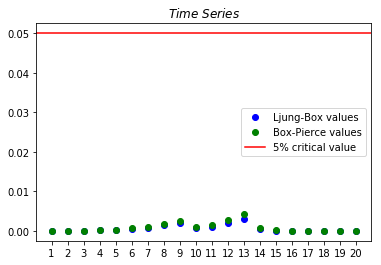

1          2          3          4          5   \
Ljung-Box: X-squared   21.791734  21.803496  23.384330  23.384763  23.476494   
Ljung-Box: p-value      0.000003   0.000018   0.000034   0.000106   0.000274   
Box-Pierce: X-squared  21.361634  21.373086  22.901919  22.902335  22.989841   
Box-Pierce: p-value     0.000004   0.000023   0.000042   0.000132   0.000339   

                              6          7          8          9          10  \
Ljung-Box: X-squared   24.017418  25.012750  25.253049  26.168014  30.450205   
Ljung-Box: p-value      0.000518   0.000755   0.001408   0.001918   0.000723   
Box-Pierce: X-squared  23.502296  24.438694  24.663184  25.511935  29.456057   
Box-Pierce: p-value     0.000645   0.000954   0.001772   0.002454   0.001051   

                              11         12         13         14         15  \
Ljung-Box: X-squared   31.030896  31.043090  31.359866  39.010397  44.650256   
Ljung-Box: p-value      0.001089   0.001940   0.002986   0.000363   0.000087   
Box-Pierce: X-squared  29.987085  29.998155  30.283671  37.128883  42.137968   
Box-Pierce: p-value     0.001592   0.002794   0.004286   0.000705   0.000214   

                              16            17            18            19  \
Ljung-Box: X-squared   53.457951  6.561253e+01  6.619224e+01  6.720914e+01   
Ljung-Box: p-value      0.000006  1.210642e-07  1.969754e-07  2.659777e-07   
Box-Pierce: X-squared  49.902646  6.053790e+01  6.104133e+01  6.191774e+01   
Box-Pierce: p-value     0.000024  8.563904e-07  1.387295e-06  1.917203e-06   

                                 20  
Ljung-Box: X-squared   6.725465e+01  
Ljung-Box: p-value     5.079016e-07  
Box-Pierce: X-squared  6.195666e+01  
Box-Pierce: p-value    3.531242e-06

In [87]:
tsdiag(A_data, lags = 20)

- (B) $Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}$

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


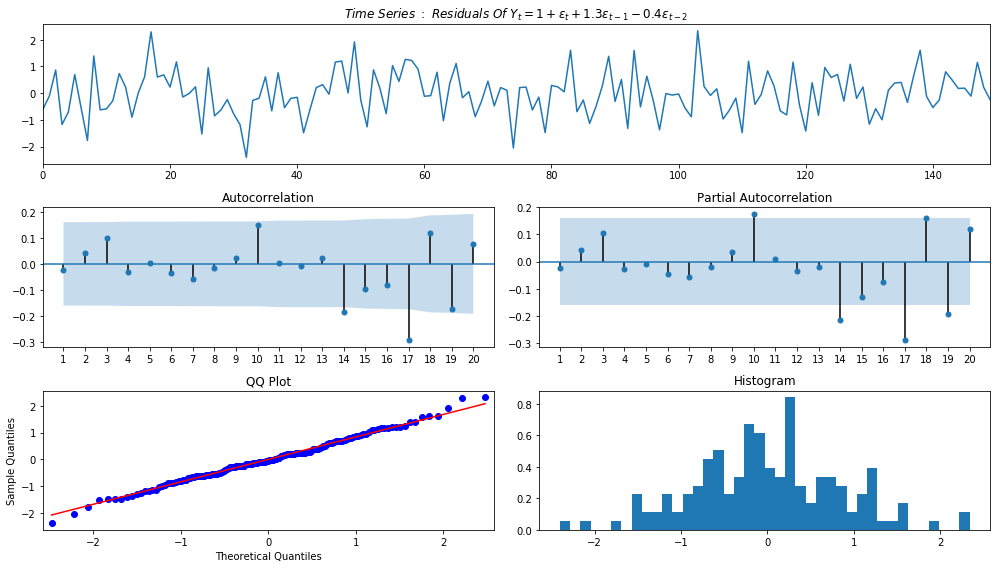

In [88]:
tsdisplay(B_mdl_1.resid, title = ":\ Residuals\ Of\ Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}")

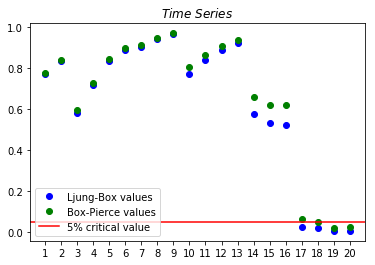

1         2         3         4         5   \
Ljung-Box: X-squared   0.082070  0.359241  1.944541  2.093183  2.094129   
Ljung-Box: p-value     0.774512  0.835587  0.583997  0.718625  0.835973   
Box-Pierce: X-squared  0.080450  0.350327  1.883479  2.026254  2.027157   
Box-Pierce: p-value    0.776688  0.839320  0.596939  0.730930  0.845375   

                             6         7         8         9         10  \
Ljung-Box: X-squared   2.278714  2.790248  2.839815  2.910845  6.474358   
Ljung-Box: p-value     0.892365  0.903704  0.944004  0.967725  0.773961   
Box-Pierce: X-squared  2.202026  2.683272  2.729578  2.795467  6.077650   
Box-Pierce: p-value    0.900212  0.912676  0.950166  0.971855  0.808698   

                             11        12        13         14         15  \
Ljung-Box: X-squared   6.475042  6.486246  6.572013  12.349313  13.923376   
Ljung-Box: p-value     0.839865  0.889617  0.922841   0.578272   0.531348   
Box-Pierce: X-squared  6.078276  6.088448  6.165752  11.334915  12.732931   
Box-Pierce: p-value    0.868091  0.911558  0.939912   0.659549   0.622918   

                              16         17         18         19         20  
Ljung-Box: X-squared   15.023596  29.845547  32.292862  37.428014  38.433388  
Ljung-Box: p-value      0.522911   0.027481   0.020295   0.007012   0.007835  
Box-Pierce: X-squared  13.702862  26.672069  28.797369  33.223059  34.082918  
Box-Pierce: p-value     0.620839   0.063056   0.050912   0.022654   0.025569

In [89]:
tsdiag(B_mdl_1.resid, lags = 20)

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


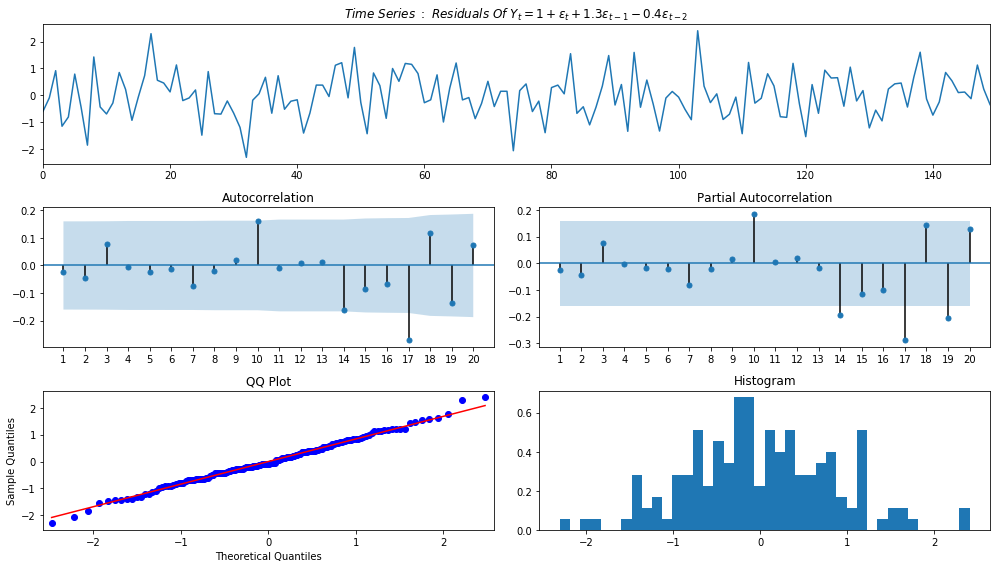

In [90]:
tsdisplay(B_mdl_auto.resid, title = ":\ Residuals\ Of\ Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}")

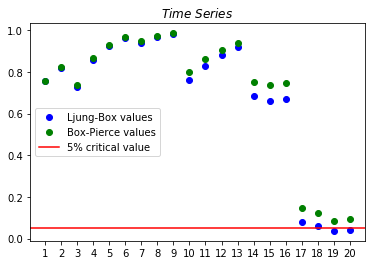

1         2         3         4         5   \
Ljung-Box: X-squared   0.096908  0.397086  1.306442  1.311911  1.400802   
Ljung-Box: p-value     0.755572  0.819925  0.727604  0.859351  0.924226   
Box-Pierce: X-squared  0.094995  0.387274  1.266717  1.271970  1.356768   
Box-Pierce: p-value    0.757920  0.823957  0.737051  0.866113  0.928983   

                             6         7         8         9         10  \
Ljung-Box: X-squared   1.432075  2.306210  2.362924  2.419964  6.609847   
Ljung-Box: p-value     0.963878  0.940970  0.967817  0.982959  0.761693   
Box-Pierce: X-squared  1.386394  2.208771  2.261755  2.314667  6.173769   
Box-Pierce: p-value    0.966681  0.947387  0.971917  0.985460  0.800459   

                             11        12        13         14         15  \
Ljung-Box: X-squared   6.623368  6.639112  6.671862  11.027969  12.271437   
Ljung-Box: p-value     0.828713  0.880513  0.918261   0.683837   0.658378   
Box-Pierce: X-squared  6.186134  6.200427  6.229946  10.127515  11.231911   
Box-Pierce: p-value    0.860660  0.905643  0.937382   0.752802   0.735988   

                              16         17         18         19         20  
Ljung-Box: X-squared   13.063555  25.735338  28.145962  31.379748  32.305132  
Ljung-Box: p-value      0.668105   0.079419   0.059868   0.036661   0.040154  
Box-Pierce: X-squared  11.930226  23.018036  25.111472  27.898485  28.689932  
Box-Pierce: p-value     0.748769   0.148664   0.121876   0.085402   0.094047

In [91]:
tsdiag(B_mdl_auto.resid, lags = 20)

Both model residuals indicate similar results in terms of adequacy - the residuals do not exhibit any autocorrelation for lag values up to `17`.

- (C) $Y_t = 1 + 1.1 Y_{t-1} + \epsilon_t$

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


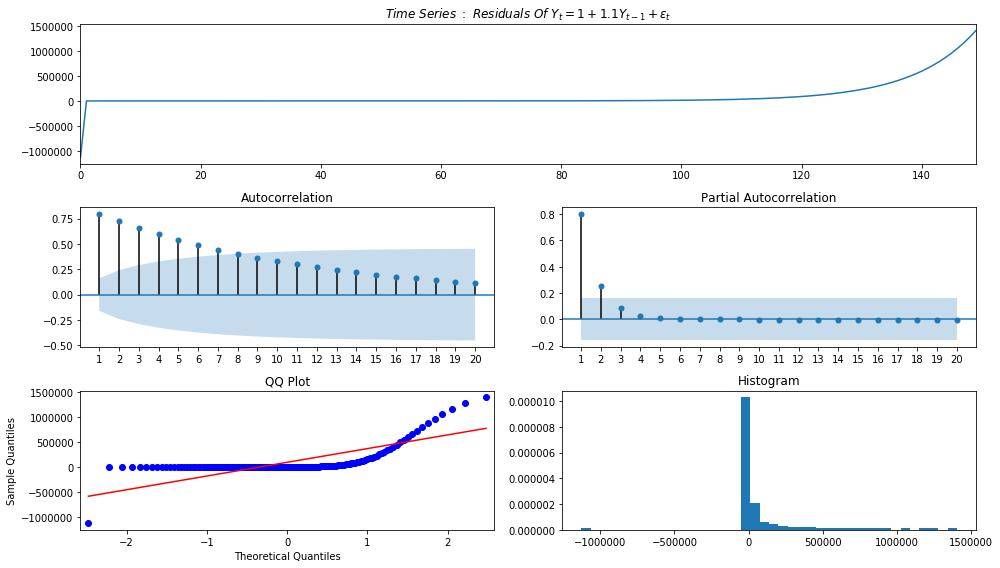

In [92]:
tsdisplay(C_mdl_1.resid, title = ":\ Residuals\ Of\ Y_t = 1 + 1.1 Y_{t-1} + \epsilon_t")

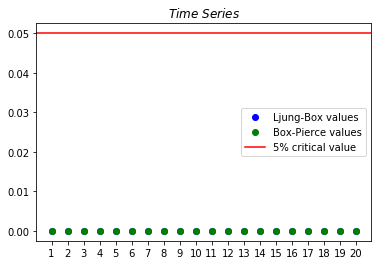

1             2             3             4   \
Ljung-Box: X-squared   9.718762e+01  1.778539e+02  2.447788e+02  3.002757e+02   
Ljung-Box: p-value     6.305970e-23  2.396208e-39  8.811516e-53  9.448013e-64   
Box-Pierce: X-squared  9.526944e+01  1.738129e+02  2.385363e+02  2.918426e+02   
Box-Pierce: p-value    1.661582e-22  1.807218e-38  1.972504e-51  6.227016e-62   

                                 5             6             7             8   \
Ljung-Box: X-squared   3.462694e+02  3.843618e+02  4.158858e+02  4.419506e+02   
Ljung-Box: p-value     1.112387e-72  6.424065e-80  9.333948e-86  1.960825e-90   
Box-Pierce: X-squared  3.357181e+02  3.718057e+02  4.014631e+02  4.258131e+02   
Box-Pierce: p-value    2.076774e-70  3.203606e-77  1.158174e-82  5.602771e-87   

                                 9             10            11  \
Ljung-Box: X-squared   4.634794e+02  4.812404e+02  4.958728e+02   
Ljung-Box: p-value     3.759820e-94  4.491068e-97  2.433271e-99   
Box-Pierce: X-squared  4.457839e+02  4.621427e+02  4.755237e+02   
Box-Pierce: p-value    2.284432e-90  5.361755e-93  5.289203e-95   

                                  12             13             14  \
Ljung-Box: X-squared    5.079086e+02   5.177906e+02   5.258870e+02   
Ljung-Box: p-value     4.594557e-101  2.429184e-102  2.998631e-103   
Box-Pierce: X-squared   4.864510e+02   4.953577e+02   5.026019e+02   
Box-Pierce: p-value     1.691862e-96   1.416846e-97   2.604212e-98   

                                  15             16             17  \
Ljung-Box: X-squared    5.325043e+02   5.378976e+02   5.422788e+02   
Ljung-Box: p-value     7.432281e-104  3.263581e-104  2.288429e-104   
Box-Pierce: X-squared   5.084791e+02   5.132337e+02   5.170673e+02   
Box-Pierce: p-value     9.084766e-99   5.336425e-99   4.782821e-99   

                                  18             19             20  
Ljung-Box: X-squared    5.458245e+02   5.486813e+02   5.509712e+02  
Ljung-Box: p-value     2.350990e-104  3.294859e-104  5.937688e-104  
Box-Pierce: X-squared   5.201464e+02   5.226085e+02   5.245670e+02  
Box-Pierce: p-value     6.031111e-99   1.000997e-98   2.070132e-98

In [93]:
tsdiag(C_mdl_1.resid, lags = 20)

The residuals clearly still exhibit autocorrelation - as indicated by the $ACF$, $PACF$ and $Ljung-Box$ tests (`p-value < 0.05`).

The automatically selected model exhibits the same problems of autocorrelated residuals:

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


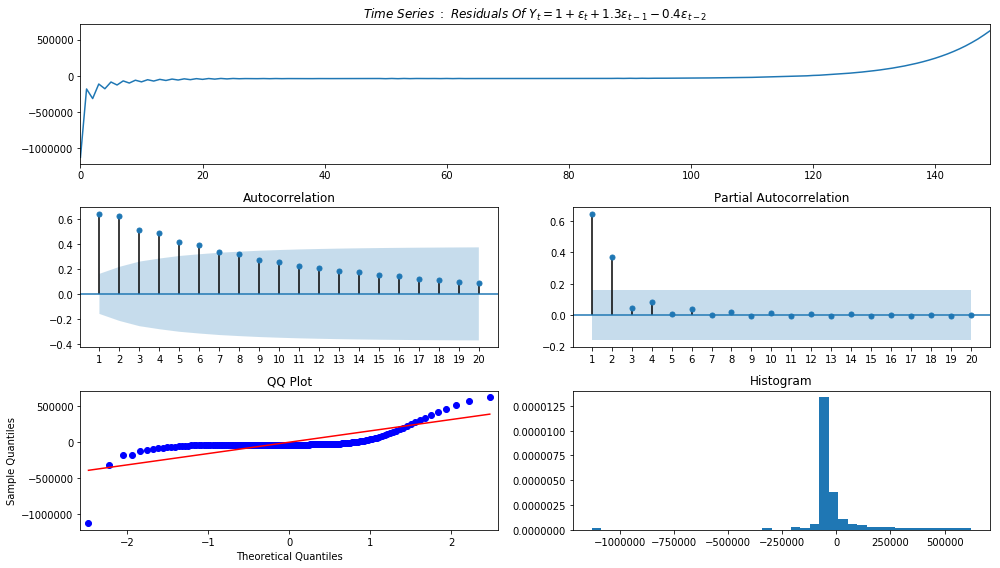

In [94]:
tsdisplay(C_mdl_auto.resid, title = ":\ Residuals\ Of\ Y_t = 1 + \epsilon_t + 1.3 \epsilon_{t-1} - 0.4 \epsilon_{t-2}")

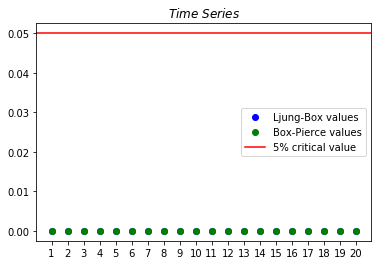

1             2             3             4   \
Ljung-Box: X-squared   6.270810e+01  1.225973e+02  1.625905e+02  1.991105e+02   
Ljung-Box: p-value     2.397283e-15  2.389627e-27  5.059007e-35  5.835990e-42   
Box-Pierce: X-squared  6.147044e+01  1.197836e+02  1.584612e+02  1.935396e+02   
Box-Pierce: p-value    4.494413e-15  9.756985e-27  3.937350e-34  9.196153e-41   

                                 5             6             7             8   \
Ljung-Box: X-squared   2.257368e+02  2.496244e+02  2.675836e+02  2.835590e+02   
Ljung-Box: p-value     8.767150e-47  4.933915e-51  4.983985e-54  1.293761e-56   
Box-Pierce: X-squared  2.189397e+02  2.415701e+02  2.584660e+02  2.733903e+02   
Box-Pierce: p-value    2.506573e-45  2.593599e-49  4.366161e-52  1.873775e-54   

                                 9             10            11            12  \
Ljung-Box: X-squared   2.957211e+02  3.064911e+02  3.147262e+02  3.220008e+02   
Ljung-Box: p-value     2.109406e-58  6.592574e-60  6.883226e-61  1.114221e-61   
Box-Pierce: X-squared  2.846722e+02  2.945920e+02  3.021228e+02  3.087274e+02   
Box-Pierce: p-value    4.633457e-56  2.160658e-57  3.127824e-58  6.893578e-59   

                                 13            14            15            16  \
Ljung-Box: X-squared   3.275619e+02  3.324675e+02  3.362046e+02  3.394988e+02   
Ljung-Box: p-value     4.025444e-62  1.942847e-62  1.604037e-62  1.596550e-62   
Box-Pierce: X-squared  3.137396e+02  3.181289e+02  3.214480e+02  3.243521e+02   
Box-Pierce: p-value    3.191151e-59  1.940334e-59  1.921552e-59  2.261270e-59   

                                 17            18            19            20  
Ljung-Box: X-squared   3.419932e+02  3.441906e+02  3.458422e+02  3.472946e+02  
Ljung-Box: p-value     2.273454e-62  3.640223e-62  7.381826e-62  1.607490e-61  
Box-Pierce: X-squared  3.265347e+02  3.284430e+02  3.298664e+02  3.311086e+02  
Box-Pierce: p-value    3.662046e-59  6.591289e-59  1.457972e-58  3.431586e-58

In [95]:
tsdiag(C_mdl_auto.resid, lags = 20)

In other words, **a non-stationary process cannot simply be directly approximated by a moving-average process**.

- (D) $Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t$

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


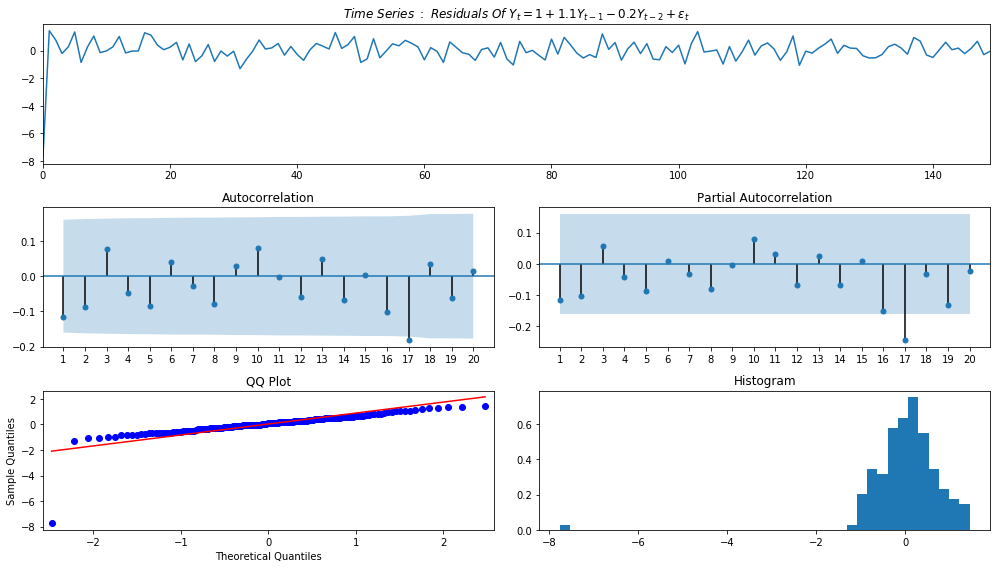

In [96]:
tsdisplay(D_mdl_1.resid, title = ":\ Residuals\ Of\ Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t")

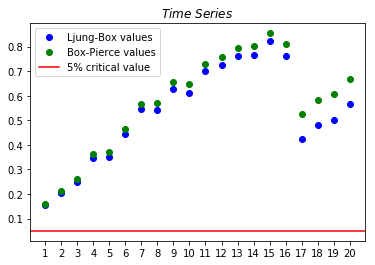

1         2         3         4         5   \
Ljung-Box: X-squared   2.021570  3.164272  4.098362  4.448134  5.561642   
Ljung-Box: p-value     0.155079  0.205536  0.251037  0.348742  0.351234   
Box-Pierce: X-squared  1.981671  3.094301  3.997665  4.333630  5.395858   
Box-Pierce: p-value    0.159215  0.212854  0.261716  0.362733  0.369501   

                             6         7         8         9         10  \
Ljung-Box: X-squared   5.828292  5.956495  6.944622  7.087055  8.159580   
Ljung-Box: p-value     0.442697  0.544838  0.542619  0.628056  0.613253   
Box-Pierce: X-squared  5.648474  5.769086  6.692205  6.824330  7.812182   
Box-Pierce: p-value    0.463696  0.566956  0.570176  0.655403  0.647177   

                             11        12        13        14        15  \
Ljung-Box: X-squared   8.160222  8.755533  9.170148  9.943673  9.946115   
Ljung-Box: p-value     0.698884  0.723657  0.759975  0.766290  0.823116   
Box-Pierce: X-squared  7.812769  8.353249  8.726948  9.419049  9.421218   
Box-Pierce: p-value    0.729971  0.756952  0.793239  0.803306  0.854484   

                              16         17         18         19         20  
Ljung-Box: X-squared   11.734507  17.425265  17.631955  18.303913  18.339406  
Ljung-Box: p-value      0.762045   0.425933   0.480134   0.502231   0.565061  
Box-Pierce: X-squared  10.997827  15.977240  16.156734  16.735855  16.766212  
Box-Pierce: p-value     0.809619   0.525449   0.581610   0.607758   0.668098

In [97]:
tsdiag(D_mdl_1.resid, lags = 20)

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


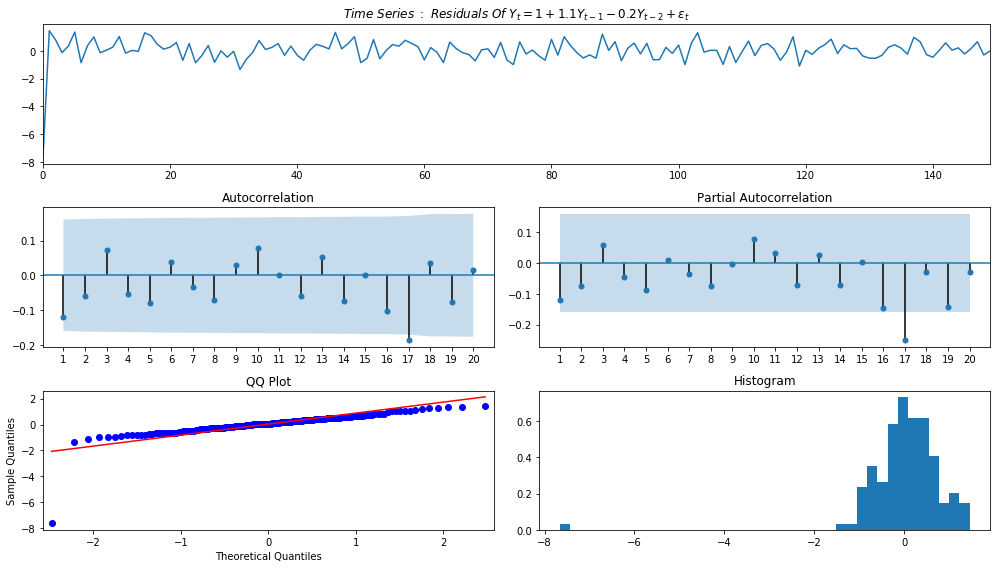

In [98]:
tsdisplay(D_mdl_auto.resid, title = ":\ Residuals\ Of\ Y_t = 1 + 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t")

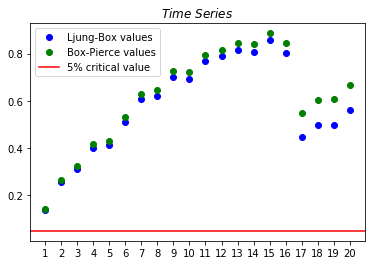

1         2         3         4         5   \
Ljung-Box: X-squared   2.175635  2.726268  3.554773  4.030814  5.023656   
Ljung-Box: p-value     0.140212  0.255858  0.313727  0.401852  0.413000   
Box-Pierce: X-squared  2.132695  2.668837  3.470089  3.927339  4.874458   
Box-Pierce: p-value    0.144187  0.263311  0.324662  0.415929  0.431393   

                             6         7         8         9         10  \
Ljung-Box: X-squared   5.258974  5.440503  6.251045  6.383579  7.352490   
Ljung-Box: p-value     0.511052  0.606370  0.619134  0.700998  0.691801   
Box-Pierce: X-squared  5.097391  5.268171  6.025388  6.148331  7.040749   
Box-Pierce: p-value    0.531384  0.627273  0.644388  0.724986  0.721592   

                             11        12        13        14        15  \
Ljung-Box: X-squared   7.352579  7.958382  8.416131  9.338994  9.339251   
Ljung-Box: p-value     0.769855  0.788374  0.815474  0.808741  0.859122   
Box-Pierce: X-squared  7.040831  7.590835  8.003412  8.829132  8.829360   
Box-Pierce: p-value    0.795767  0.816233  0.843378  0.841838  0.886269   

                              16         17         18         19         20  
Ljung-Box: X-squared   11.104707  17.127124  17.336060  18.377335  18.420792  
Ljung-Box: p-value      0.802977   0.445786   0.500125   0.497380   0.559710  
Box-Pierce: X-squared  10.385749  15.655364  15.836808  16.734222  16.771390  
Box-Pierce: p-value     0.845722   0.548384   0.603935   0.607868   0.667764

In [99]:
tsdiag(D_mdl_auto.resid, lags = 20)

We see that the $p-value$ of the Ljung-Box statistic is greater than 0.05 for the first 20 lags - we have no grounds to reject the null hypothesis of no autocorrelation in the residuals. So, both the specified underlying amodel and the automatically selected model is adequate.

Note the histogram and `Q-Q` plot - since the first value of the series is quite different from the rest - one value (and hence, one residual) appears to be an outlier. Generally, when simulating data, a number of the first values generated in the series are treated as `burn-in` observations - they are usually dropped from the beginning of the sample. For example, if we need to generate $N$ observations, we generate $N + 20$ and drop the first $20$ observations.

- (E) $Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}$

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


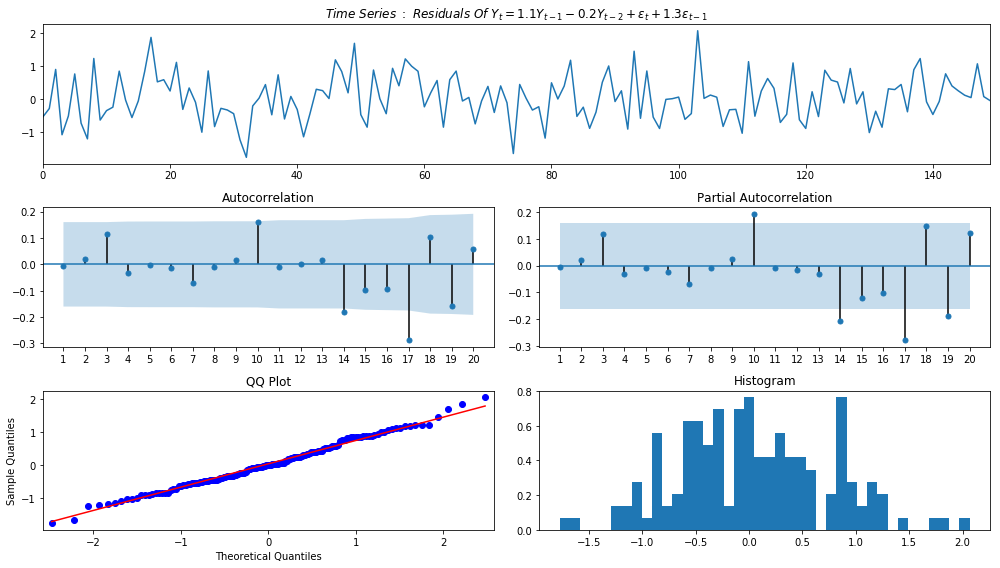

In [100]:
tsdisplay(E_mdl_1.resid, title = ":\ Residuals\ Of\ Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}")

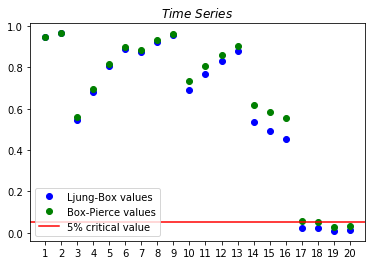

1         2         3         4         5   \
Ljung-Box: X-squared   0.004791  0.073798  2.142657  2.295163  2.297494   
Ljung-Box: p-value     0.944816  0.963774  0.543331  0.681650  0.806635   
Box-Pierce: X-squared  0.004697  0.071887  2.072692  2.219178  2.221402   
Box-Pierce: p-value    0.945362  0.964695  0.557457  0.695520  0.817739   

                             6         7         8         9         10  \
Ljung-Box: X-squared   2.320685  3.139493  3.152206  3.196080  7.388230   
Ljung-Box: p-value     0.887971  0.871805  0.924446  0.956011  0.688355   
Box-Pierce: X-squared  2.243372  3.013698  3.025575  3.066273  6.927465   
Box-Pierce: p-value    0.896011  0.883732  0.932742  0.961609  0.732275   

                             11        12        13         14         15  \
Ljung-Box: X-squared   7.400594  7.400621  7.442580  12.896453  14.436268   
Ljung-Box: p-value     0.765777  0.830044  0.877928   0.534693   0.492732   
Box-Pierce: X-squared  6.938771  6.938795  6.976614  11.856395  13.223994   
Box-Pierce: p-value    0.804020  0.861632  0.903353   0.617834   0.585001   

                              16         17         18         19         20  
Ljung-Box: X-squared   15.979955  30.227166  32.134195  36.516392  37.145786  
Ljung-Box: p-value      0.454361   0.024753   0.021196   0.009115   0.011240  
Box-Pierce: X-squared  14.584875  27.051185  28.707289  32.484051  33.022349  
Box-Pierce: p-value     0.555227   0.057321   0.052076   0.027548   0.033551

In [101]:
tsdiag(E_mdl_1.resid, lags = 20)

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


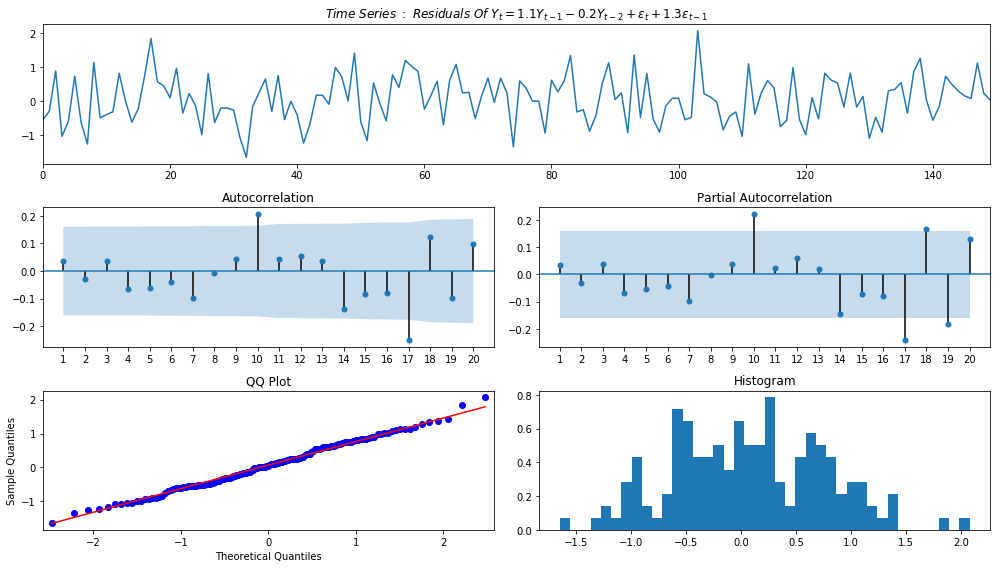

In [102]:
tsdisplay(E_mdl_auto.resid, title = ":\ Residuals\ Of\ Y_t = 1.1 Y_{t-1} - 0.2 Y_{t-2} + \epsilon_t + 1.3 \epsilon_{t-1}")

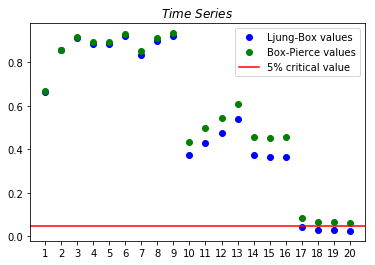

1         2         3         4         5   \
Ljung-Box: X-squared   0.187042  0.313526  0.527301  1.153642  1.730842   
Ljung-Box: p-value     0.665390  0.854907  0.912854  0.885671  0.884991   
Box-Pierce: X-squared  0.183351  0.306505  0.513249  1.114866  1.665484   
Box-Pierce: p-value    0.668509  0.857913  0.915971  0.891906  0.893219   

                             6         7         8         9          10  \
Ljung-Box: X-squared   1.975352  3.494672  3.501633  3.818195  10.802439   
Ljung-Box: p-value     0.921951  0.835790  0.899063  0.922966   0.373116   
Box-Pierce: X-squared  1.897125  3.326485  3.332989  3.626642  10.059498   
Box-Pierce: p-value    0.928913  0.853248  0.911758  0.934226   0.435289   

                              11         12         13         14         15  \
Ljung-Box: X-squared   11.136594  11.626969  11.866991  15.058031  16.262487   
Ljung-Box: p-value      0.431892   0.476084   0.538580   0.374199   0.364824   
Box-Pierce: X-squared  10.365074  10.810283  11.026618  13.881760  14.951507   
Box-Pierce: p-value     0.497878   0.545244   0.608588   0.458557   0.454916   

                              16         17         18         19         20  
Ljung-Box: X-squared   17.352138  28.153252  30.797571  32.446950  34.083936  
Ljung-Box: p-value      0.363172   0.043179   0.030377   0.027817   0.025562  
Box-Pierce: X-squared  15.912120  25.363095  27.659477  29.080981  30.481035  
Box-Pierce: p-value     0.459111   0.086873   0.067430   0.064722   0.062425

In [103]:
tsdiag(E_mdl_auto.resid, lags = 20)

For the automatically selected model, the Box-Pierce test statistic of the first 20 lags is greater than 0.05, indicating no autocorrelation in the residuals. On the other hand, manually specifying the true model shows that there would still be autocorrelation after the 18th lag. On the other hand, the autocorrelation significance is only for a large lag, which is usually not too important.

---

## 4.1 Model Selection

We will compare the AIC and BIC values to select the best model.

**The model with the lower AIC/BIC value is the preferred one. BIC penalizes model complexity more heavily.**

- (A) $Y_t = 1 + (1 + 0.5L)\epsilon_t$

In [104]:
pd.DataFrame([[A_mdl_1.aic, A_mdl_auto.aic], [A_mdl_1.bic, A_mdl_auto.bic]], index = ["AIC", "BIC"], columns = ["Manual", "Auto"])

Manual        Auto
AIC  248.807681  248.002137
BIC  257.839587  260.044678

The automatically specified model is better in terms of it its lower AIC. On the other hand, the BIC is lower of our manually specified model. 

In this case, we should examine the residuals and maybe even forecasts in order to determine, which model is more appropriate. 

However, since we automatically selected the model order in terms of lower AIC values and since the task requires to compare in terms of AIC, we will opt to use the auto specified model.

- (B) $Y_t = 1 + (1 + 1.3L - 0.4 L^2)\epsilon_t$

In [105]:
pd.DataFrame([[B_mdl_1.aic, B_mdl_auto.aic], [B_mdl_1.bic, B_mdl_auto.bic]], index = ["AIC", "BIC"], columns = ["Manual", "Auto"])

Manual        Auto
AIC  382.030162  381.640507
BIC  394.072703  393.683048

AIC and BIC indicate that the automatically specified model is better.

- (C) $(1 - 1.1L) Y_t = 1 + \epsilon_t$

In [106]:
pd.DataFrame([[C_mdl_1.aic, C_mdl_auto.aic], [C_mdl_1.bic, C_mdl_auto.bic]], index = ["AIC", "BIC"], columns = ["Manual", "Auto"])

Manual         Auto
AIC  4196.705872  3988.997097
BIC  4205.737777  4010.071544

The automatically specified model is better since itsAIC and BIC are lower.

- (D) $(1 - 1.1L + 0.2L^2) Y_t = 1 + \epsilon_t$

In [107]:
pd.DataFrame([[D_mdl_1.aic, D_mdl_auto.aic], [D_mdl_1.bic, D_mdl_auto.bic]], index = ["AIC", "BIC"], columns = ["Manual", "Auto"])

Manual        Auto
AIC  277.102626  276.754731
BIC  289.145167  288.797272

Automatically specified model is better because its AIC and BIC are lower.

- (E) $(1 - 1.1L + 0.2L^2) Y_t = (1 + 1.3L)\epsilon_t$

In [108]:
pd.DataFrame([[E_mdl_1.aic, E_mdl_auto.aic], [E_mdl_1.bic, E_mdl_auto.bic]], index = ["AIC", "BIC"], columns = ["Manual", "Auto"])

Manual        Auto
AIC  332.449460  330.010492
BIC  344.492001  345.063669

Automatically specified model is better in terms of AIC. In terms of BIC, the manually specified model is better.

Because the task requires to compare in terms of AIC, we will go with the automatically specified model.

As we can see, we do not always get a clear-cut result of which model is better if we have mode than one criteria for model selection.

Since in practice we would not know the true lag order, the automatic model selection produced acceptable models.

---

## 4.2 Forecasting

From the results in (4.1) - the automatically specified models have lower AIC and BIC values. Furthermore, from the residual diagnostics in tasks (3.1)-(3.3), the residuals of the automatically specified models are just as good (in terms of the significance of autocorrelation) as the residuals of the models with the true lag order specification. 

Hence, we will use forecasts of the automatically specified models.

- (A) $Y_t = 1 + (1 + 0.5L)\epsilon_t$

We will show how to get the predictions as values in this example. We will generally focus on the plots, so this is provided only as an example

In [109]:
A_mdl_auto.fittedvalues[-1]

0.9198674825687396

In [110]:
A_mdl_auto.predict(start = N - 1, end = N + 19)

array([0.91986748, 1.11660321, 1.02511125, 1.04568106, 1.04105642,
       1.04209616, 1.0418624 , 1.04191496, 1.04190314, 1.0419058 ,
       1.0419052 , 1.04190533, 1.0419053 , 1.04190531, 1.04190531,
       1.04190531, 1.04190531, 1.04190531, 1.04190531, 1.04190531,
       1.04190531])

Note that if we start the forecast from a historical datapoint (remember that our sample size is $N$ and indexes in `Python` start from `0`, so effectively, our last osbervation is at index `N-1`), we actually get the **fitted** value.

We can also plot the fitted values and the forecasts along with their standard errors:

In [111]:
A_mdl_auto.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

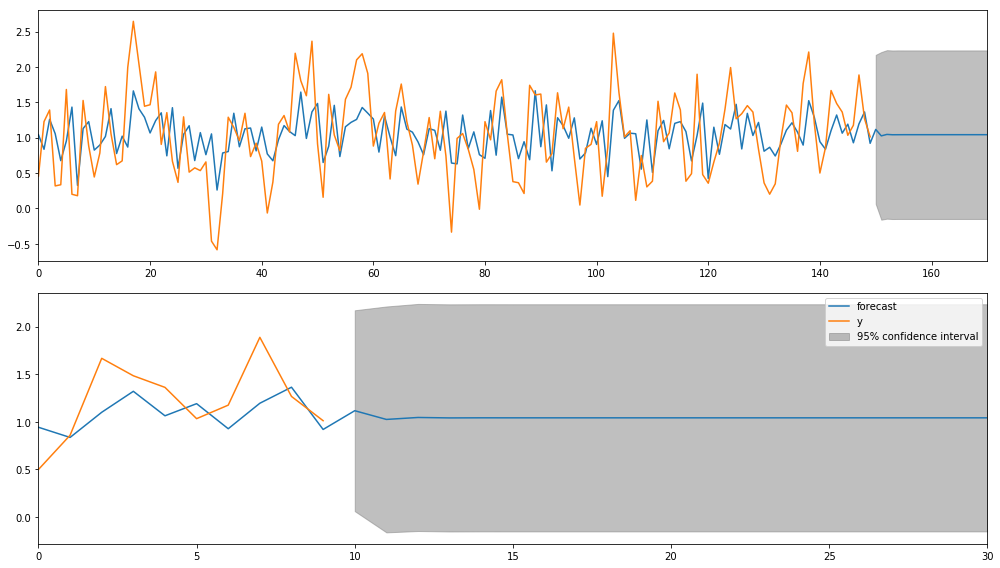

In [112]:
fig = plt.figure(figsize = (14,8))
A_mdl_auto.plot_predict(end = A_data.size + 20, ax = fig.add_subplot(211))
plt.legend().remove()
A_mdl_auto.plot_predict(start = A_data.size - 10, end = A_data.size + 20, ax = fig.add_subplot(212))
plt.tight_layout()
plt.show()

We see that the initial forecast has some variation at $T + 1$, but for $T + 2, ..., T+20$ the forecast gets closer to the process mean (note that the estimated auto-sepcified model is not a pure $MA$ model, hence the forecast does not immediately go to the mean after the first forecast step).

- (B) $Y_t = 1 + (1 + 1.3L - 0.4 L^2)\epsilon_t$

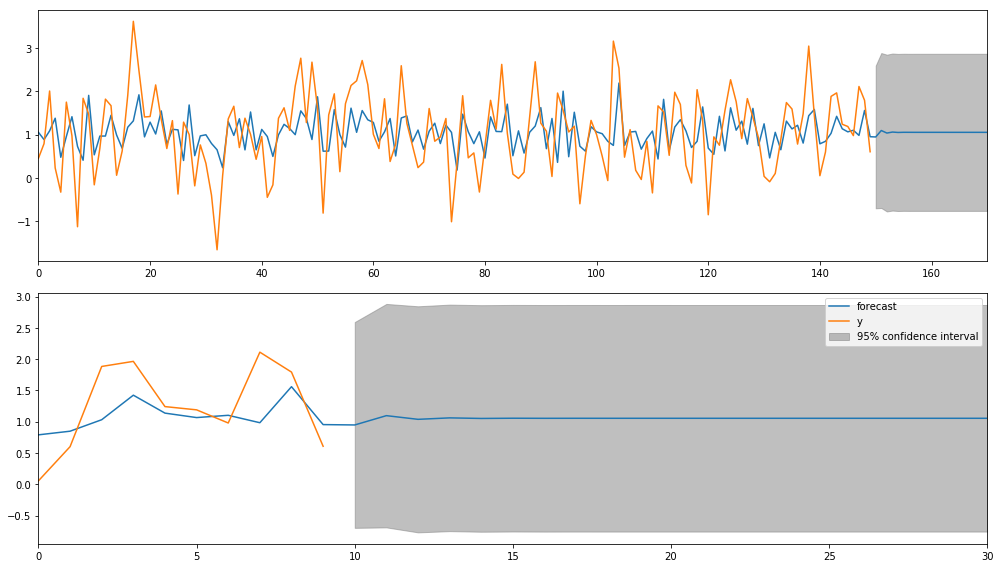

In [113]:
fig = plt.figure(figsize = (14,8))
B_mdl_auto.plot_predict(end = B_data.size + 20, ax = fig.add_subplot(211))
plt.legend().remove()
B_mdl_auto.plot_predict(start = B_data.size - 10, end = B_data.size + 20, ax = fig.add_subplot(212))
plt.tight_layout()
plt.show()

Similarly to (A), the process there is some variation for the first couple of forecasts, but the later ones are close to the process mean.

- (C) $(1 - 1.1L) Y_t = 1 + \epsilon_t$

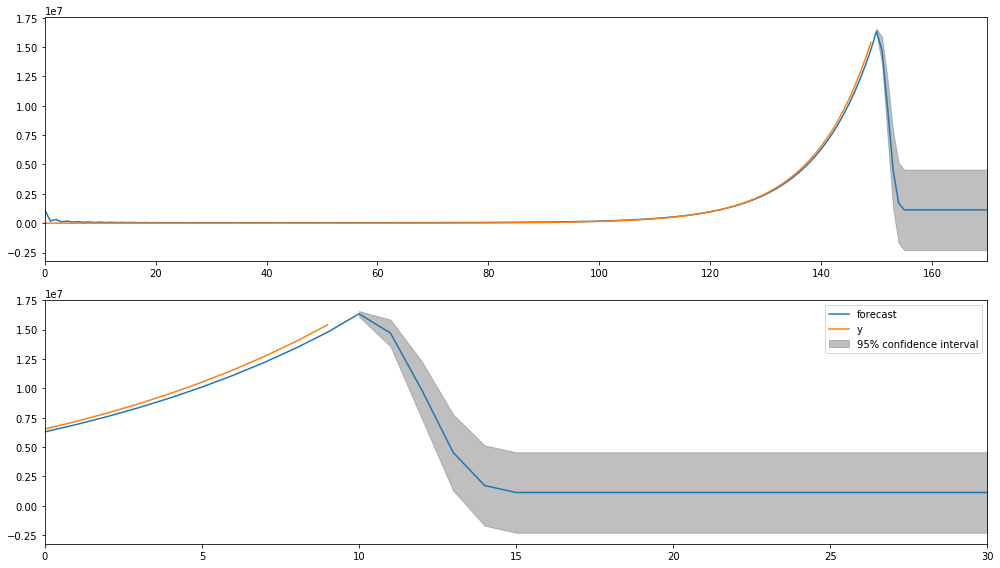

In [114]:
fig = plt.figure(figsize = (14,8))
C_mdl_auto.plot_predict(end = C_data.size + 20, ax = fig.add_subplot(211))
plt.legend().remove()
C_mdl_auto.plot_predict(start = C_data.size - 10, end = C_data.size + 20, ax = fig.add_subplot(212))
plt.tight_layout()
plt.show()

graphically, the fitted values **appear** close to the ture values for this **non-stationary process**. However, the forecast is declining, whereare the fitted values and the true values appear to grow exponentially. this does not apepar to make any sense intuitively. Remember that we attempt to estimate a stationary model for the data, regardless whether this is true or not, so the forecast is quite poor. 

Overall, these kinds of non-stationary processes need separate methods for dealing with non-stationarity and cannot simply be modelled by specifying an approxiamte stationary model on the initial data.

- (D) $(1 - 1.1L + 0.2L^2) Y_t = 1 + \epsilon_t$

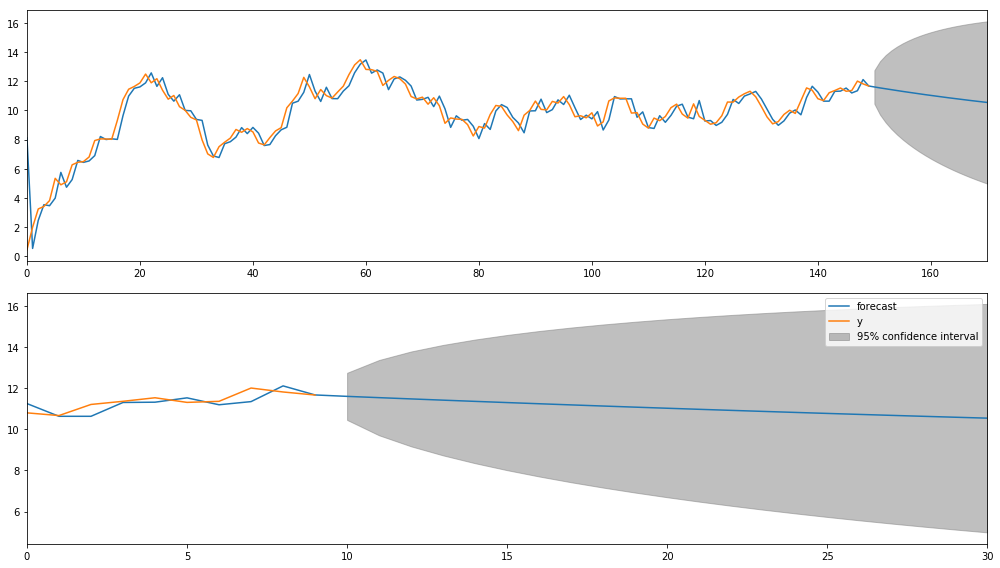

In [115]:
fig = plt.figure(figsize = (14,8))
D_mdl_auto.plot_predict(end = D_data.size + 20, ax = fig.add_subplot(211))
plt.legend().remove()
D_mdl_auto.plot_predict(start = D_data.size - 10, end = D_data.size + 20, ax = fig.add_subplot(212))
plt.tight_layout()
plt.show()

Fitted values appear to fit the data quite well, the forecast is declining - it appears that it is approaching the mean of the process, but it may take longer than 20 periods in the future.

- (E) $(1 - 1.1L + 0.2L^2) Y_t = (1 + 1.3L)\epsilon_t$

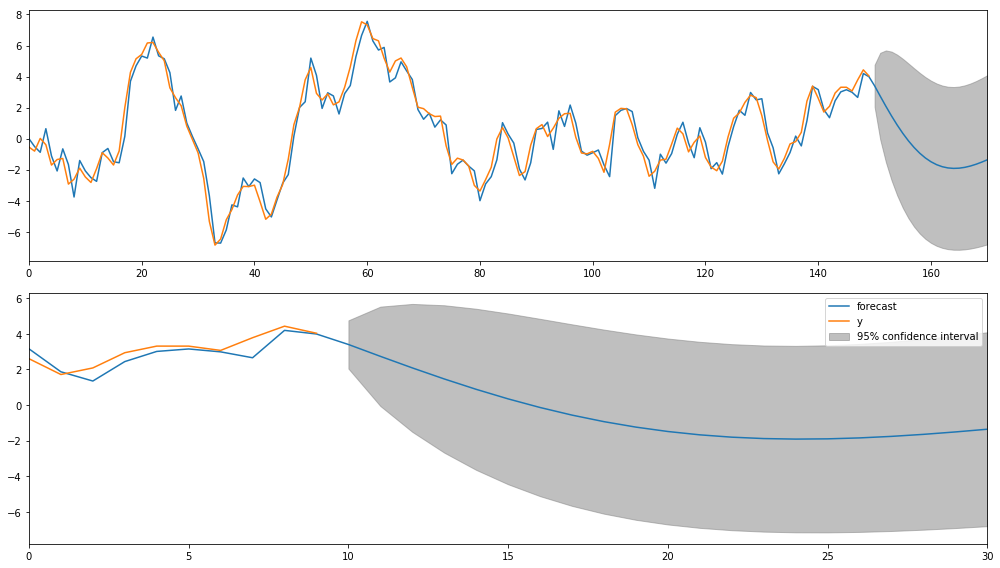

In [116]:
fig = plt.figure(figsize = (14,8))
E_mdl_auto.plot_predict(end = E_data.size + 20, ax = fig.add_subplot(211))
plt.legend().remove()
E_mdl_auto.plot_predict(start = E_data.size - 10, end = E_data.size + 20, ax = fig.add_subplot(212))
plt.tight_layout()
plt.show()

The model appears to fit the data quite nicely. furthermore, the forecasts exhibit quite a bit of variation - rougly the first 10 forecasts are declining. Then, the decline slows down and even appears to begin increasing.

To sum up: 

- (A) and (B) are moving average processes, which are governed by random shocks, hence the fitted values are quite varying, even though the automatic selection, selected ARMA models, which have both AR and MA components.

- If the true underlying process has a significant autoregressive part, the automatically selected models **appear** to fit the data quite well, even if it isnt stationary. 

- On the other hand, the forecast of a non-stationary process does not appear to make sense, indicating overall a poor model for (E).

-------

-------

# Stationarity and invertibility problems when estimating simulated or empirical data

As we have seen, in case of non-stationary or non-invertible processes, we may still get an estimated model, with stationary and invertible coefficients. The model may not fit the data well, but is an attempt of fitting a *good* model (in terms of stationarity and invertibility). However, sometimes estimation may result in an error, stating that the non-stationarity and/or noninvertibility doesn ot allow to estimate a model.

To make matters worse, sometimes even if we know that a process is stationary and/or invertible, we may still get an error, stating otherwise. To give an example of when an error may occur, generate the following $\rm AR(1)$ process

In [143]:
np.random.seed(1)
N = 100
AR_spec_test = smt.arima_process.ArmaProcess(ar = np.array([1, 0.99]), ma = [1])
AR_bad_example =  AR_spec_test.generate_sample(N, scale = 0.5)

We can verify that this process is both stationary and invertible:

In [144]:
AR_spec_test.isstationary

True

In [145]:
AR_spec_test.isinvertible

True

If we try to estimate this model:

In [146]:
spec_1 = smt.arima_model.ARMA(AR_bad_example, order = (1, 0))

we would get an error:

In [147]:
try:
    mdl_1 = spec_1.fit(trend = 'nc')
except ValueError as err:
        print('Handling run-time error:', err)

Handling run-time error: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


Sometimes we may even get this kind of error if our coefficients are relatively small - for example the following $\rm ARMA$ model:

In [148]:
np.random.seed(123)
N = 150
ARMA_spec_test = smt.arima_process.ArmaProcess(ar = np.array([1, 0.5]), ma = [1, 0.5])
ARMA_bad_example = ARMA_spec_test.generate_sample(N, scale = 0.5)

We can verify that this process is both stationary and invertible:

In [149]:
ARMA_spec_test.isstationary

True

In [150]:
ARMA_spec_test.isinvertible

True

In [151]:
spec_2 = smt.arima_model.ARMA(ARMA_bad_example, order = (1, 1))

In [152]:
try:
    mdl_2 = spec_2.fit(trend = 'nc')
except ValueError as err:
        print('Handling run-time error:', err)

Handling run-time error: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


**which makes no sense.**

To bypass this, we can specify the starting parameters, `start_params`, when fitting:

In [153]:
mdl_2 = spec_2.fit(trend = 'nc', start_params = [0, 0])

In [154]:
print(mdl_2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.1581      2.276      0.069      0.945      -4.302       4.618
ma.L1.y       -0.1634      2.272     -0.072      0.943      -4.617       4.290


If our specified model has a constant:

In [155]:
np.random.seed(123)
N = 150
ARMA_spec_test = smt.arima_process.ArmaProcess(ar = np.array([1, 0.5]), ma = [1, 0.5])
ARMA_bad_example =  3 + ARMA_spec_test.generate_sample(N, scale = 0.5)

Then the starting parameters have to include the constant term as well:

In [156]:
spec_3 = smt.arima_model.ARMA(ARMA_bad_example, order = (1, 1))
mdl_3 = spec_3.fit(trend = 'c', start_params = [0, 0, 0])

In [157]:
print(mdl_3.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0289      0.045     67.573      0.000       2.941       3.117
ar.L1.y        0.6815      2.073      0.329      0.743      -3.382       4.745
ma.L1.y       -0.6792      2.079     -0.327      0.744      -4.753       3.395


Do note that non-stationarity, even when the true underlying process is stationary, can be cause by:
    
- a small sample size;
- a random chance;
- combination of coefficients, which lead to lag function roots that are close to the unit circle;
- a specific lag order selection in the AR, or MA, may result in a non-stationary and/or non-invertible process. **This may be remedied by attempting to specify a different order model.**
- bugs in the econometric software (not as frequent);

Similarly, if the process is non-invertible, we may not always get the estimates. This, unfortunately, may also cause false error for invertible processes for similar reasons, as with non-stationarity:

In [158]:
np.random.seed(123)
N = 100
MA_spec_test = smt.arima_process.ArmaProcess(ar = np.array([1]), ma = [1, -1.3, 0.5])
MA_bad_example =  MA_spec_test.generate_sample(N, scale = 1)

We can verify the stationarity and invertibility as before:

In [159]:
MA_spec_test.isstationary

True

In [160]:
MA_spec_test.isinvertible

True

We can calculate the roots:

In [161]:
MA_spec_test.maroots

array([1.3-0.55677644j, 1.3+0.55677644j])

And their absolute values:

In [162]:
np.abs(MA_spec_test.maroots)

array([1.41421356, 1.41421356])

To verify that they are outside the unit circle (i.e. their absolute values are > 1).

If we try to estimate this model:

In [163]:
spec_4 = smt.arima_model.ARMA(MA_bad_example, order = (0, 2))

we would get an error

In [164]:
try:
    mdl_4 = spec_4.fit(trend = 'nc')
except ValueError as err:
        print('Handling run-time error:', err)

Handling run-time error: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


Note that this time, the MA coefficient is non-invertible, even though the model specification and `MA_spec_test.isinvertible` indicated that this process is invertible.

Similarly to before, we can specify the starting parameter values:

In [165]:
mdl_4 = spec_4.fit(trend = 'nc', start_params = [0, 0])

In [166]:
print(mdl_4.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -1.2818      0.086    -14.974      0.000      -1.450      -1.114
ma.L2.y        0.5181      0.079      6.518      0.000       0.362       0.674


---
---

If we want to avoid checking for stationarity and invertibility entirely, we can specify `transparams = False`:

In [167]:
print(spec_4.fit(trend = 'nc', transparams = False, start_params = [0, 0]).summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -2.2943      0.473     -4.846      0.000      -3.222      -1.366
ma.L2.y        1.0000      0.408      2.448      0.016       0.199       1.801


**NOTE: the results are entirely different! Furthermore, it may be possible that the final parameters are exactly the same as the ones in `start_params`. Therefore, if is advised against using this option.**

---
---